In [1]:
from torchvision import transforms as tfs
from torch.utils import data
import PIL.ImageOps
from utils import CustomDataGANV4 as cdata
import numpy as np
from utils import utils
import os
import pickle
from utils import Discriminator as netD
from utils import GeneratorV3 as netG
import torch.nn as nn
import torch.optim as optim
import torch
from utils.Plotter import VisdomLinePlotter
import tqdm
from scipy import stats

In [2]:
available_device = 'cuda'

transformations = [
                   #tfs.RandomHorizontalFlip(p=0.7), 
                   #tfs.RandomAffine(0, scale=(0.7, 1.), fillcolor=(255, 255, 255)), 
                   #tfs.RandomRotation((0,360), fill=(255,255, 255)), 
                   tfs.Grayscale(),
                   tfs.RandomRotation(degrees=(0,45), fill=(255,)),
                   tfs.Resize((128, 128)),
                   tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                   tfs.ToTensor()
]

transformations_target = [
                   #tfs.RandomHorizontalFlip(p=0.7), 
                   #tfs.RandomAffine(0, scale=(0.7, 1.), fillcolor=(255, 255, 255)), 
                   #tfs.RandomRotation((0,360), fill=(255,255, 255)), 
                   tfs.Grayscale(),
                   #tfs.RandomRotation(degrees=(0,45), fill=(255,)),
                   tfs.Resize((128, 128)),
                   tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                   tfs.ToTensor()
]

imagenet_data = cdata.CustomDataGAN(
                            '../vasijas/data/perfiles_CATA/png_clasificados/',
                            #'../vasijas/data/perfiles_CATA/png_clasificados_bk_2021',
                            '../fragmentos_vasijas/morfo/',
                            transform=tfs.Compose(transformations),
                            transform_target= tfs.Compose(transformations_target))

#imagenet_data.black_image = stats.rv_discrete(name='custm', values=([False, False], [0.5, 0.5]))
#imagenet_data.flip_image = stats.rv_discrete(name='custm', values=([False, False], [0.5, 0.5]))

BATCH_SIZE = 4

In [3]:
splits_len = round(len(imagenet_data.samples)*0.2), round(len(imagenet_data.samples)*0.1), round(len(imagenet_data.samples)*0.7)+1
splits_len, np.sum(splits_len), len(imagenet_data.samples) 
#### Random split
splits = utils.random_split(imagenet_data, splits_len)
train_loader = data.DataLoader(splits[2], batch_size=BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(splits[1], batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(splits[0], batch_size=BATCH_SIZE, shuffle=False)

In [4]:
import sh

In [5]:
sh.cp('datapickle/gan_0_bbk.pickle', 'datapickle/gan_0.pickle')

In [6]:
print('Load indexs files')

file_pi2 = open('datapickle/gan_0.pickle', 'rb') 
splits[0].indices = pickle.load(file_pi2)

file_pi2 = open('datapickle/gan_1.pickle', 'rb') 
splits[1].indices = pickle.load(file_pi2)

file_pi2 = open('datapickle/gan_2.pickle', 'rb') 
splits[2].indices = pickle.load(file_pi2)

Load indexs files


In [7]:
import matplotlib.pyplot as plt

In [8]:
def imshow_msk(imgs, k):
    plt.figure(figsize=(12,5))
    titles = ['ind - {}: Input 0'.format(k), 'Input 1', 'Result', 'Target', 'Position']
    for i in range(0,4):
        plt.subplot(1, 5, i+1)
        plt.imshow(imgs[i], cmap="gray")
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[i])
   
    
    plt.subplot(1, 5, 5)
    plt.imshow(imgs[2].reshape(128, 128))
    plt.imshow(imgs[0].reshape(128, 128), alpha=0.6)
    #plt.imshow(imgs[1].reshape(128, 128), alpha=0.5)

    plt.xticks([])
    plt.yticks([])
    plt.title(titles[4])

    plt.show()

In [9]:
def imshow_msk_v2(imgs, k):
    plt.figure(figsize=(12,5))
    #titles = ['ind - {}: Base'.format(k), 'Tope', 'Target']
    titles = ['Input 0', 'Input 1', 'Result']
    for i,j in enumerate([0,1,3]):
        plt.subplot(1, 3, i+1)
        plt.imshow(imgs[j], cmap="gray")
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[i])
   
    plt.savefig('dataset_fig/row_{}.png'.format(k), bbox_inches='tight',  dpi=300)
    plt.show()
    
    #imshow_msk_v2

In [10]:
def imshow_msk_v3(imgs, k):
    plt.figure(figsize=(12,5))
    #titles = ['ind - {}: Base'.format(k), 'Tope', 'Target']
    titles = ['ind - {}: Input 0'.format(k), 'Input 1', 'Result']
    for i,j in enumerate([0,1,3]):
        
            
        plt.subplot(1, 3, i+1)
        if j != 1:
            plt.imshow(imgs[j], cmap="gray")
        else:
            plt.imshow(np.ones(imgs[j].shape)*255, cmap="gray_r")
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[i])
   
    plt.savefig('dataset_fig/row_{}.png'.format(k), bbox_inches='tight',  dpi=300)
    plt.show()
    
    #imshow_msk_v2

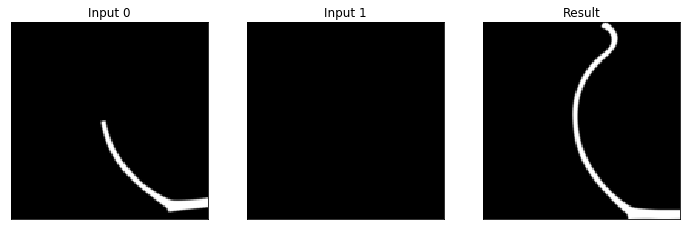

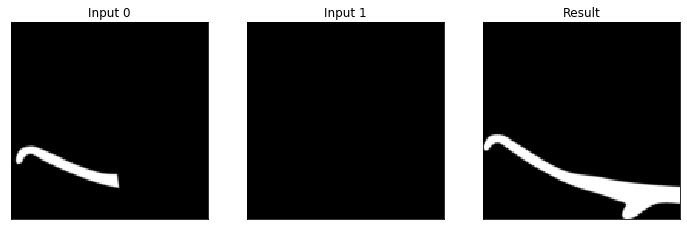

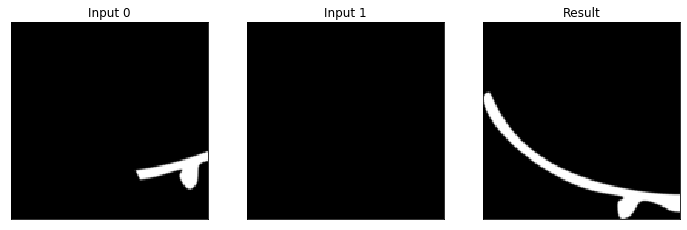

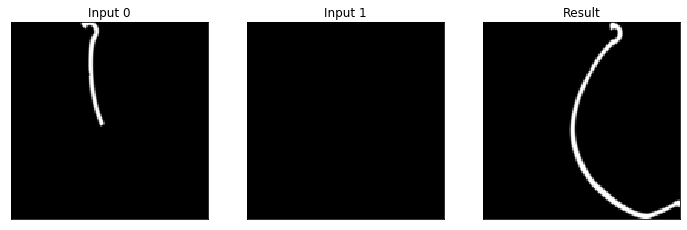

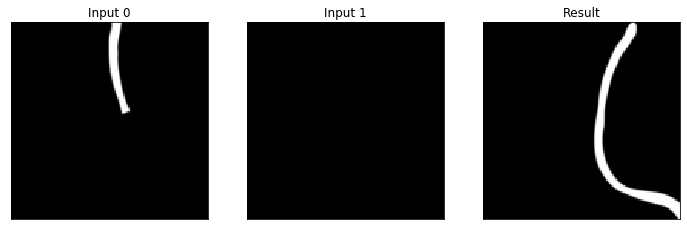

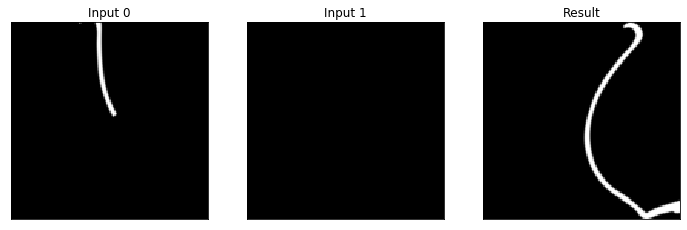

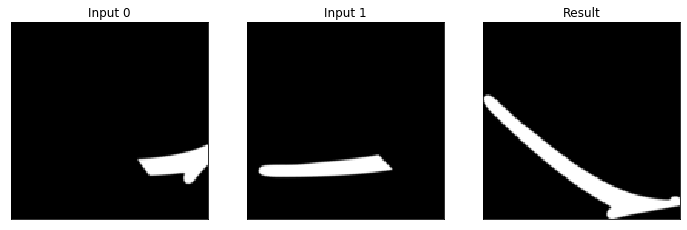

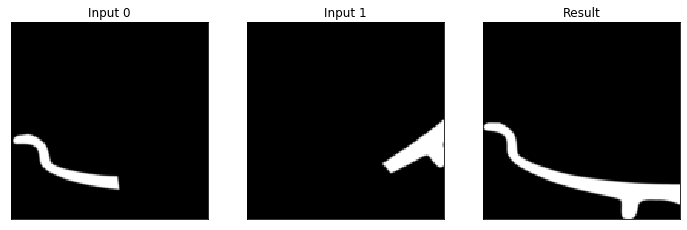

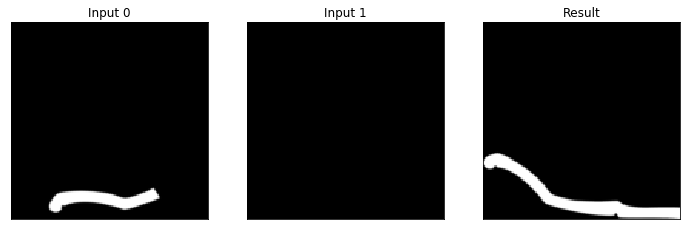

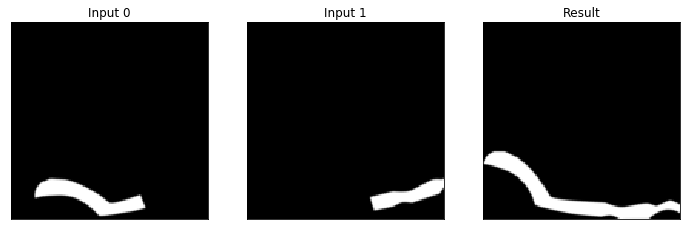

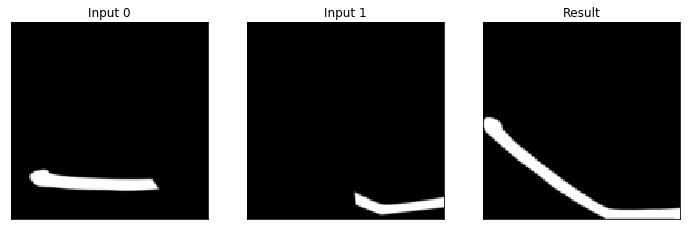

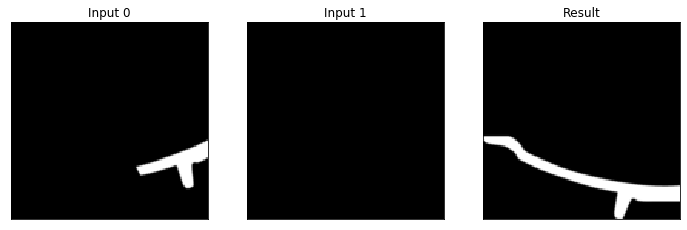

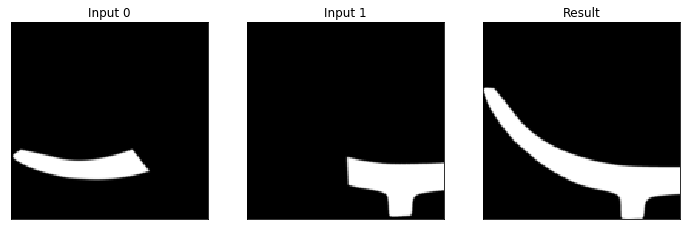

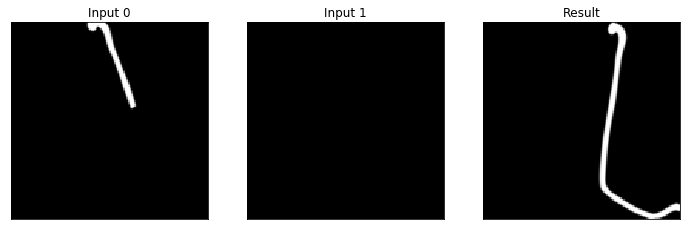

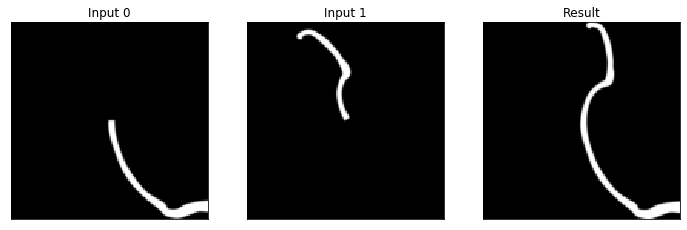

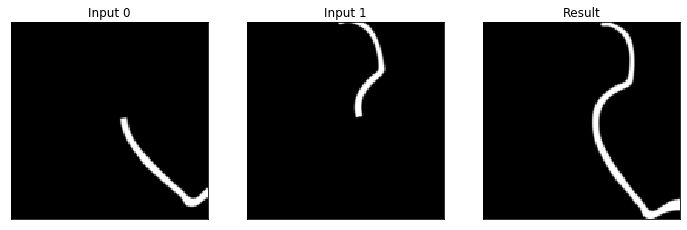

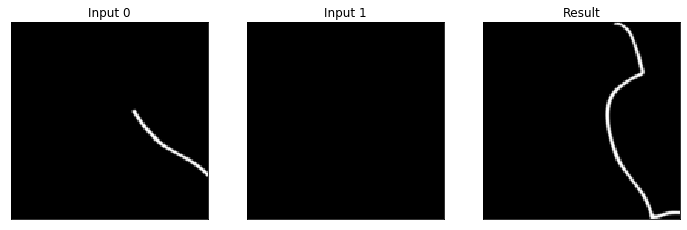

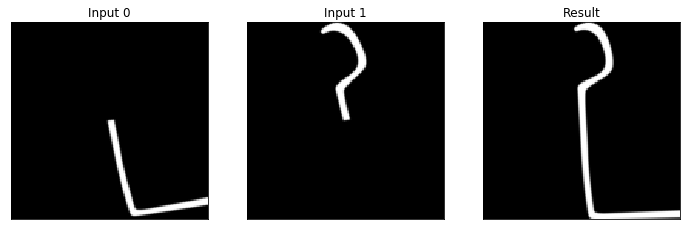

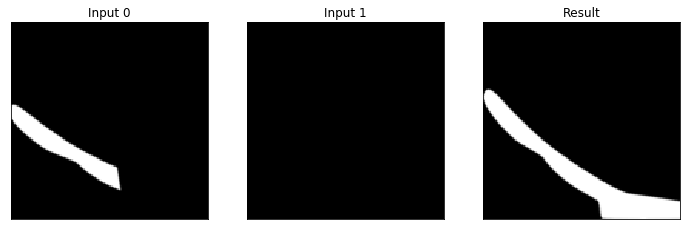

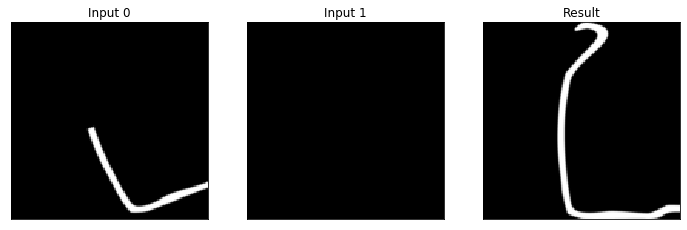

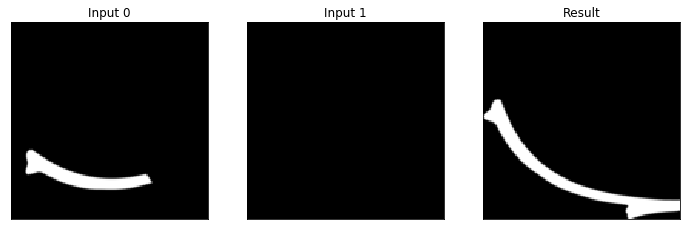

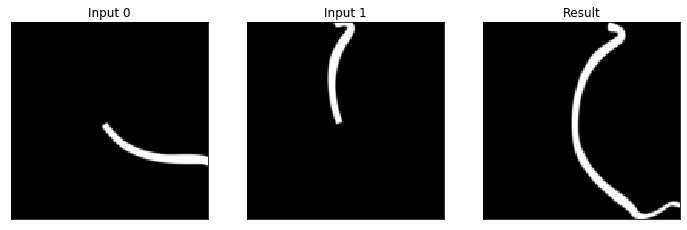

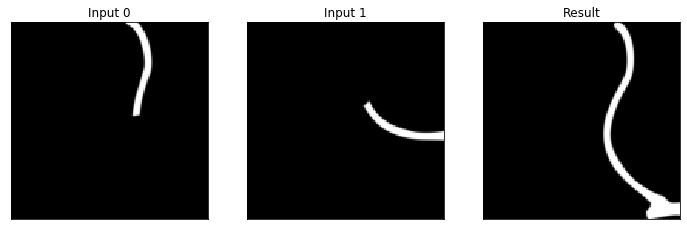

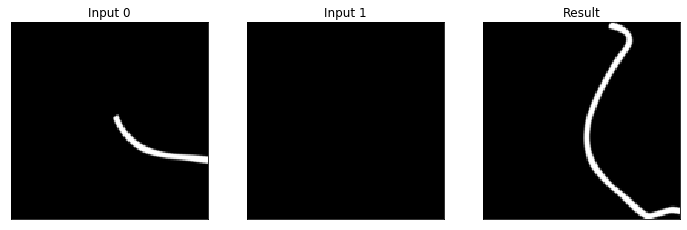

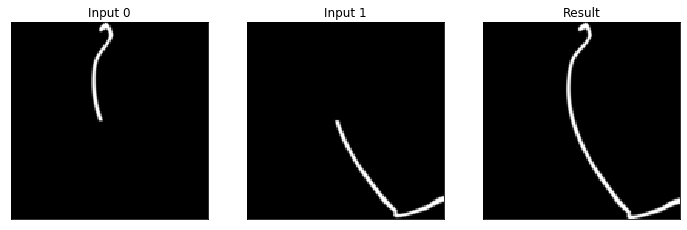

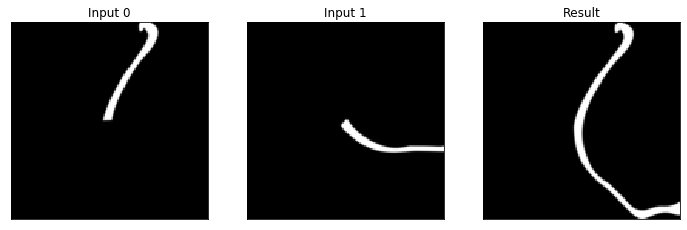

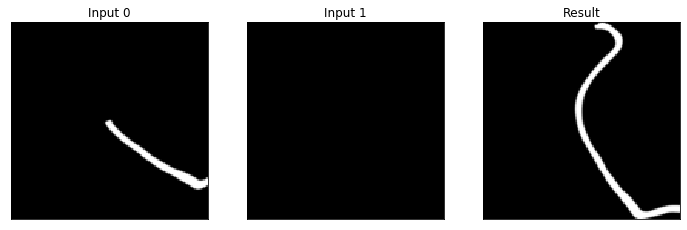

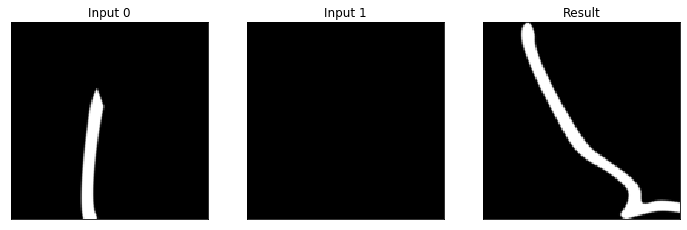

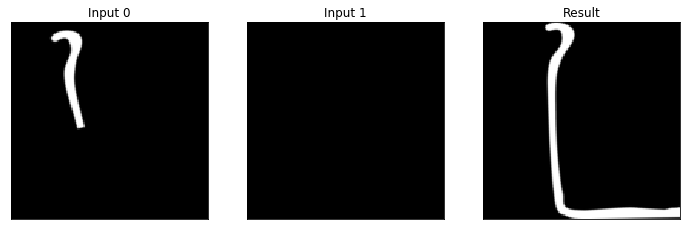

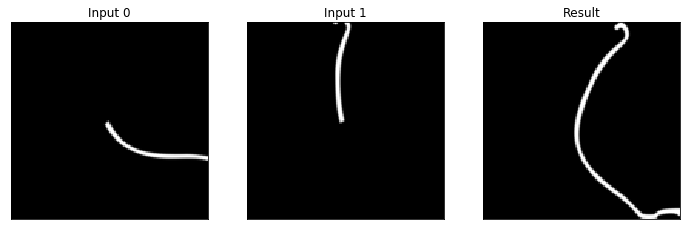

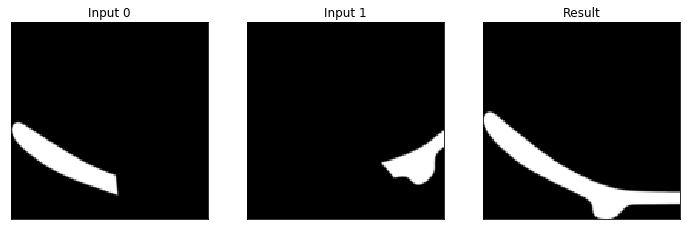

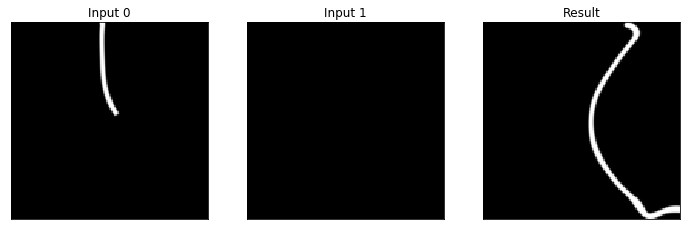

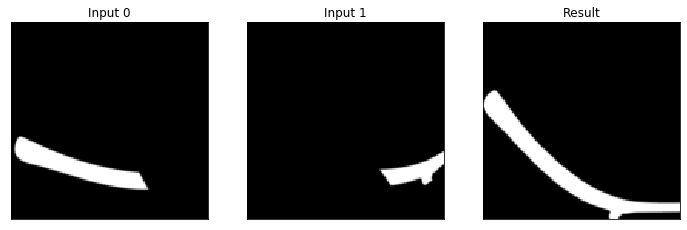

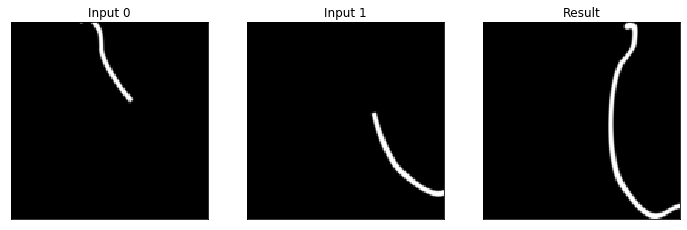

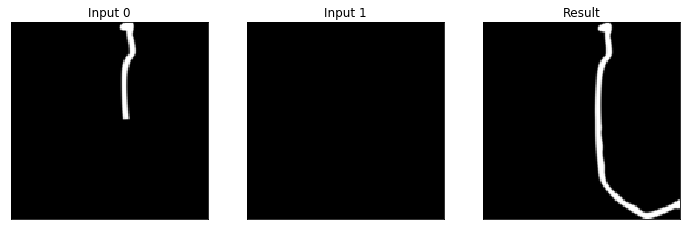

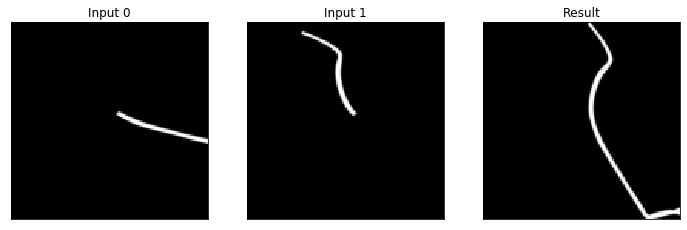

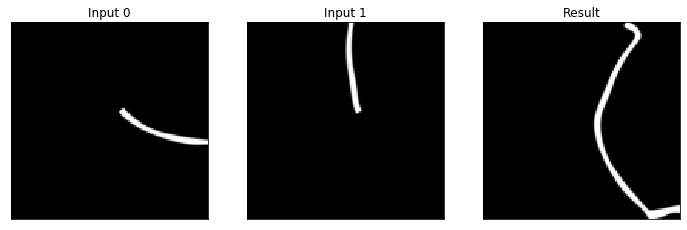

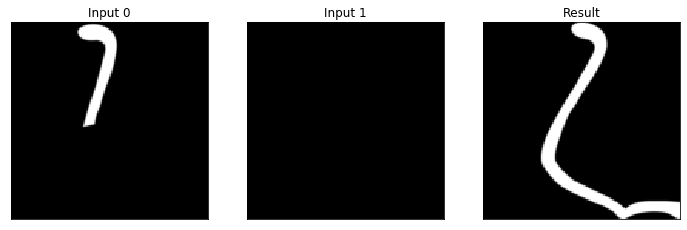

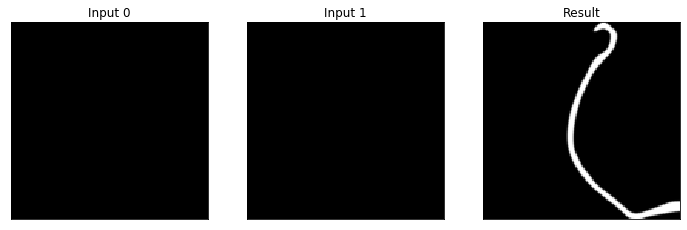

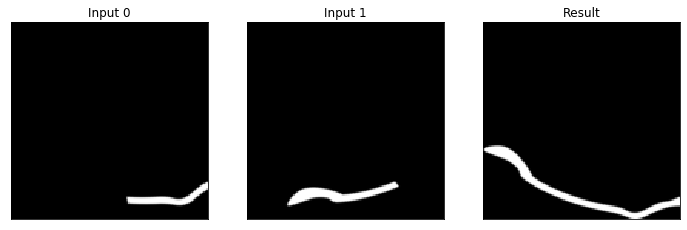

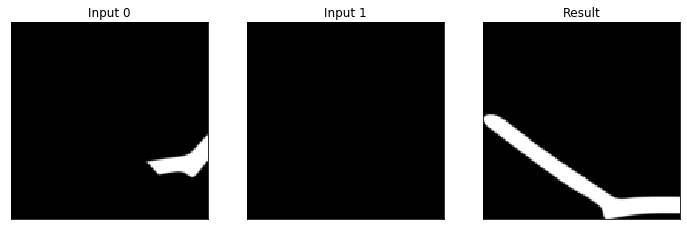

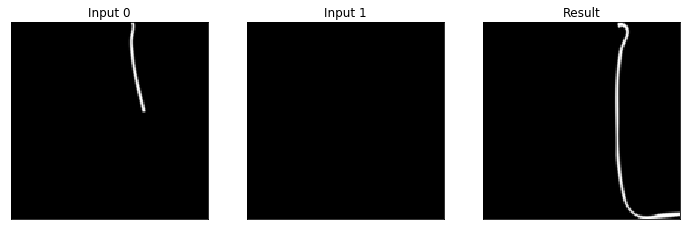

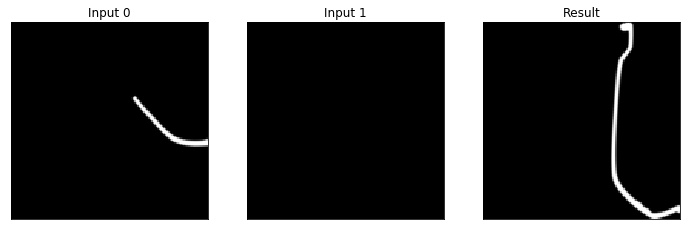

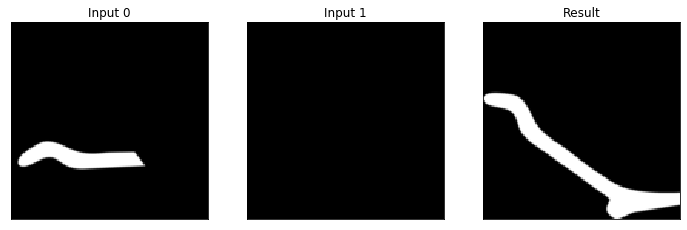

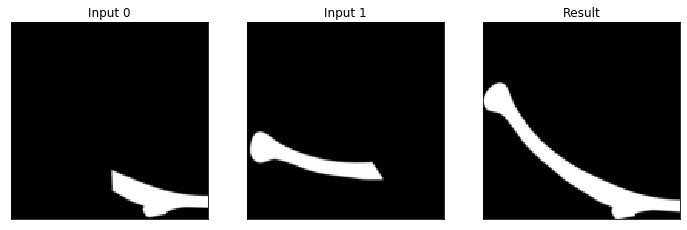

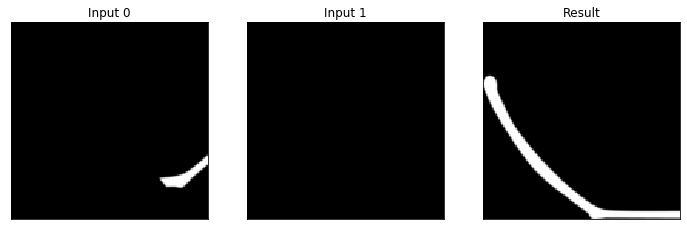

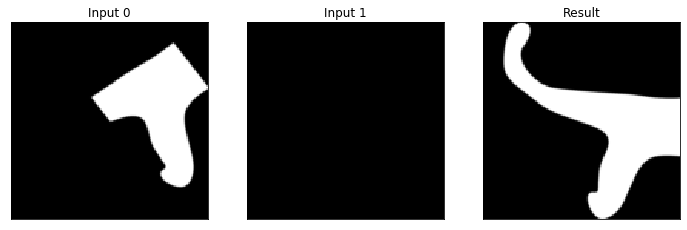

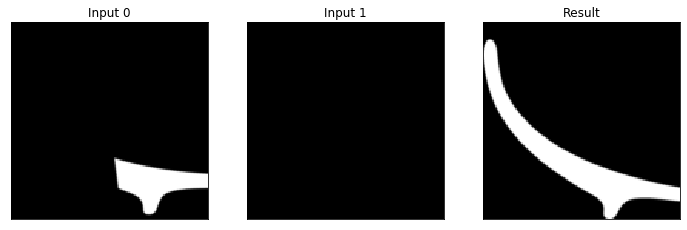

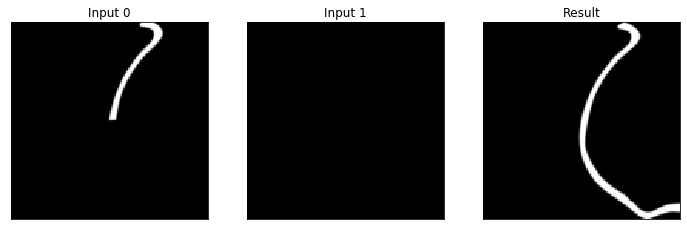

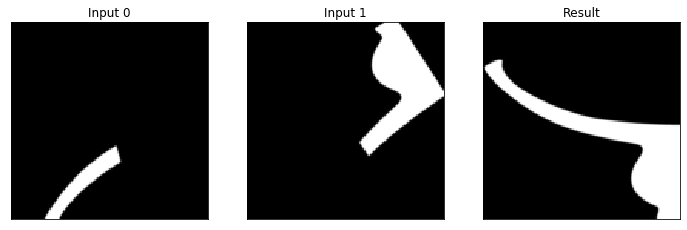

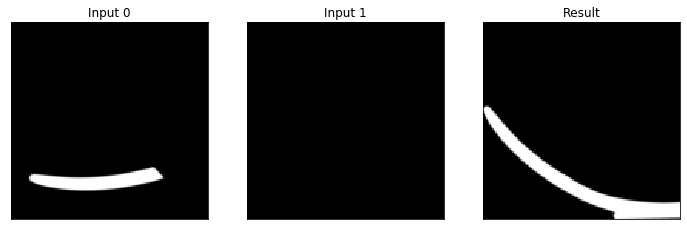

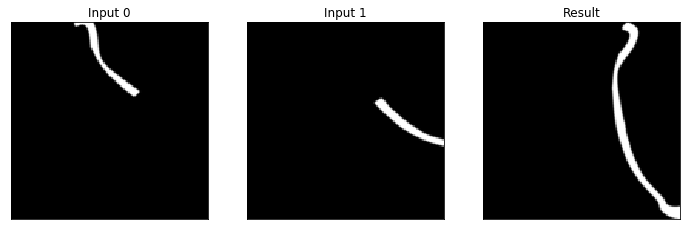

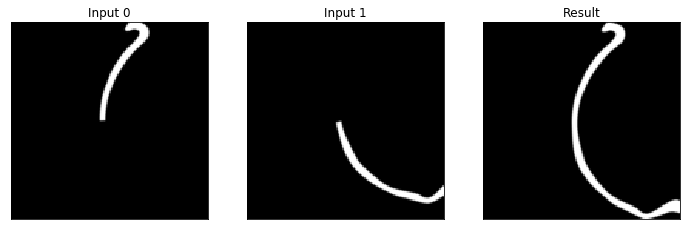

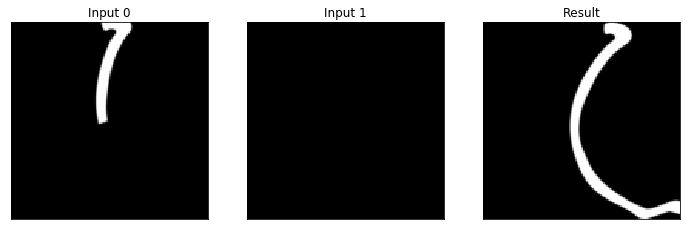

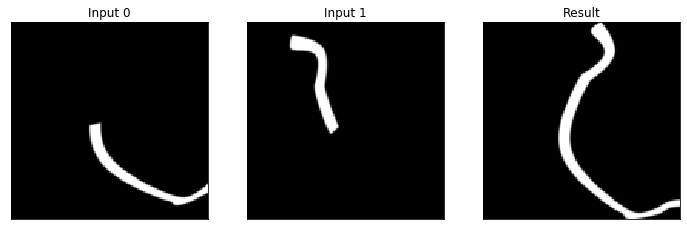

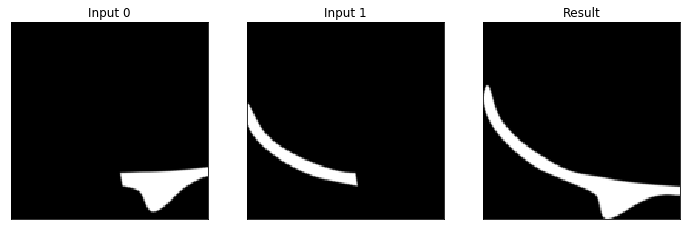

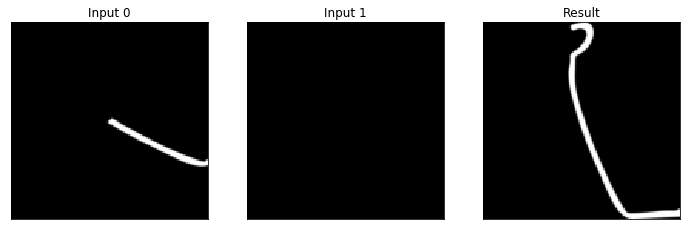

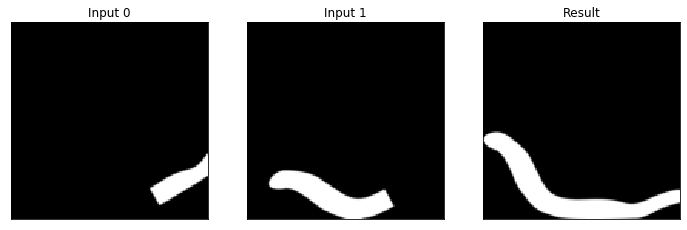

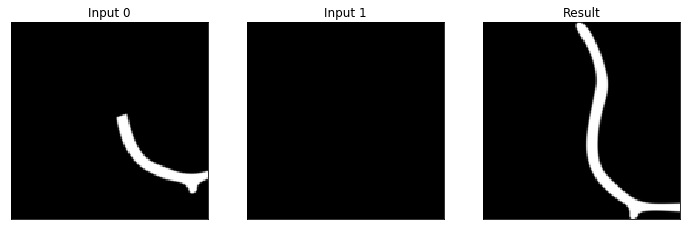

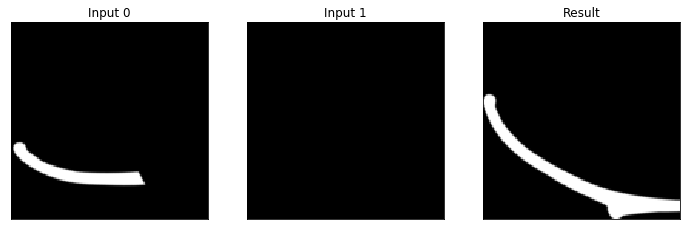

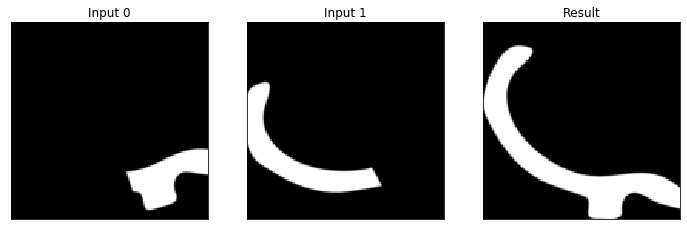

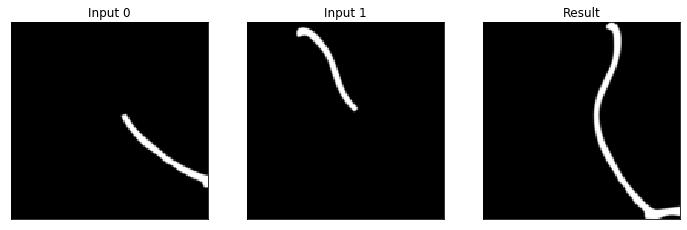

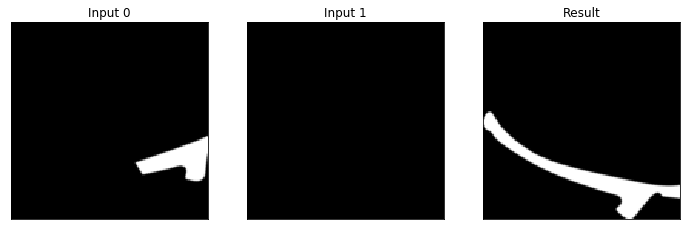

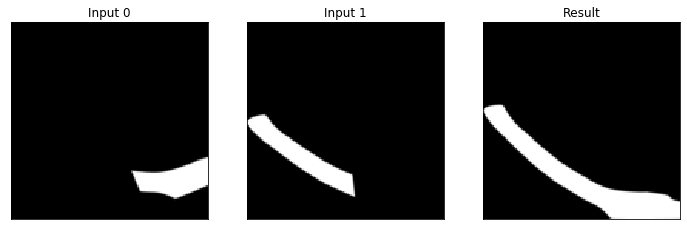

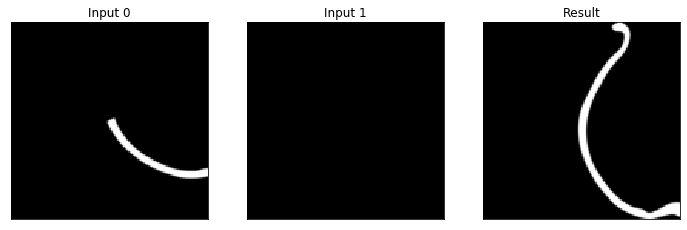

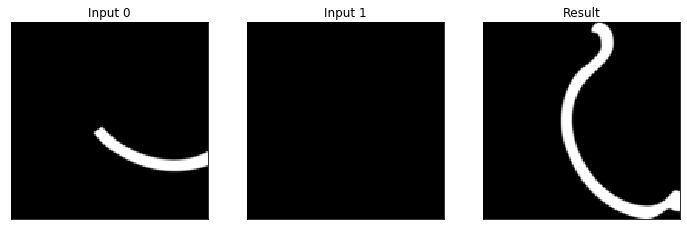

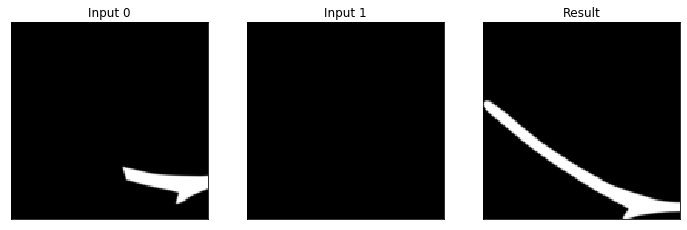

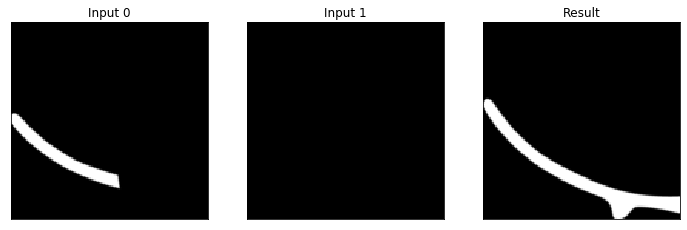

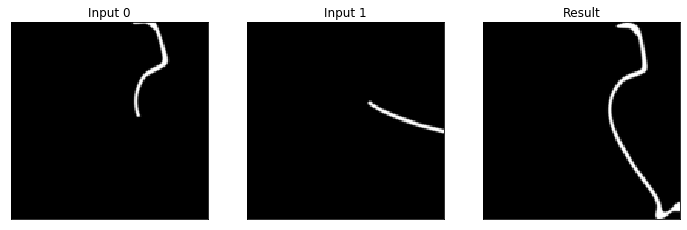

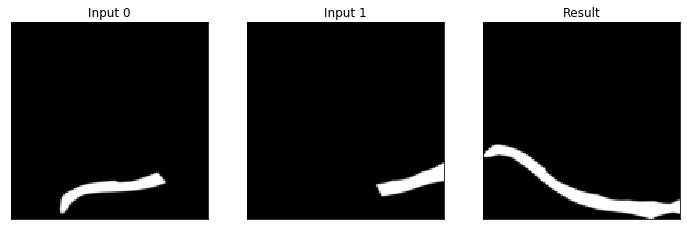

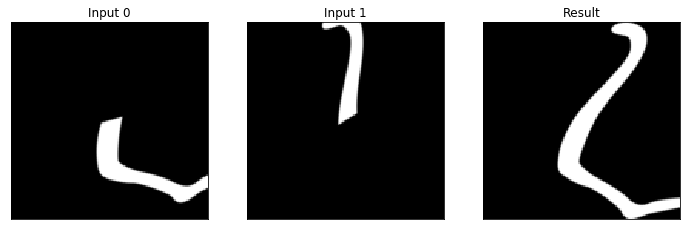

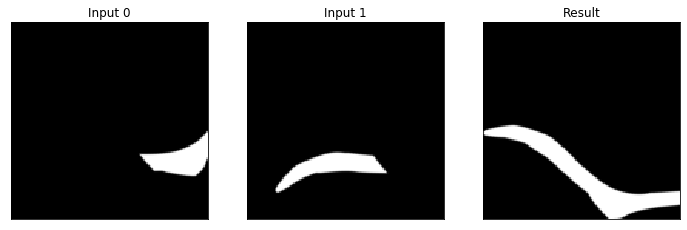

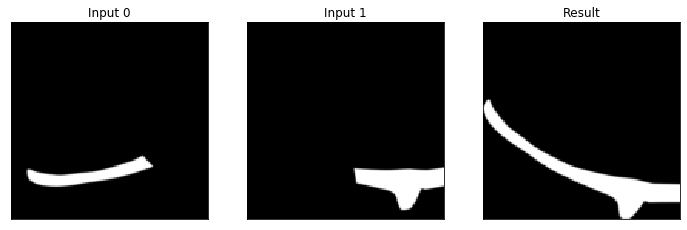

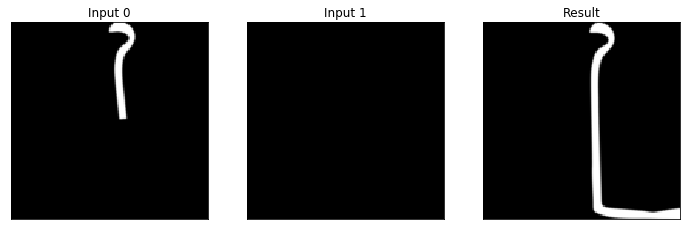

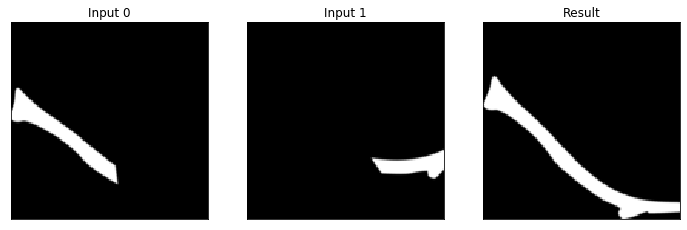

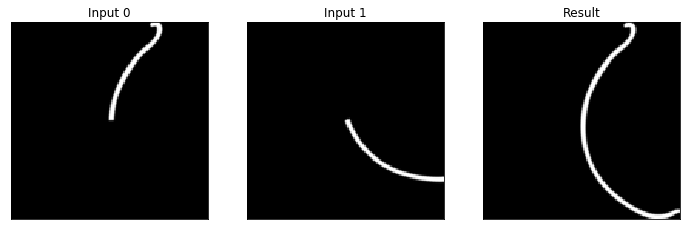

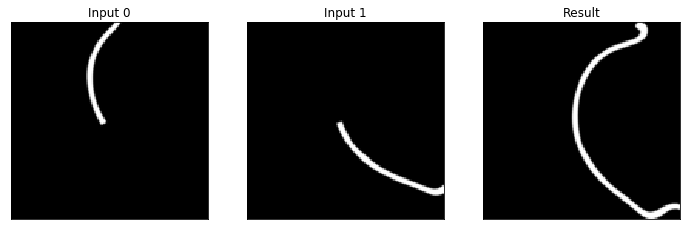

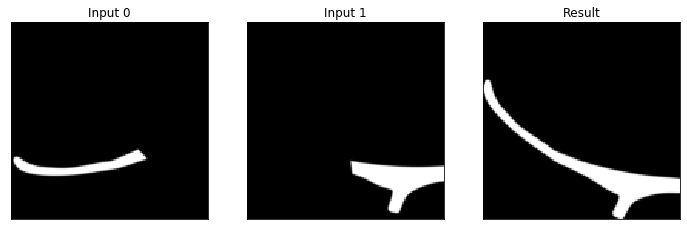

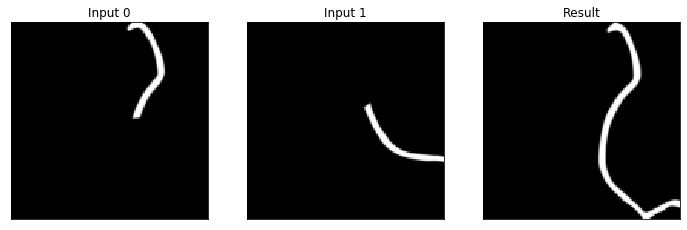

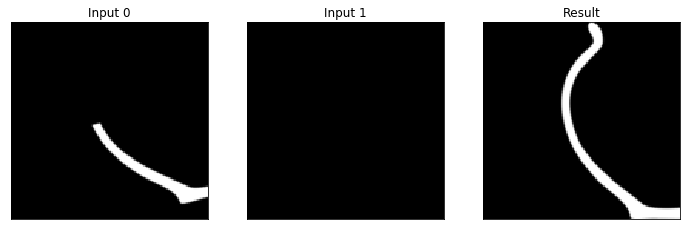

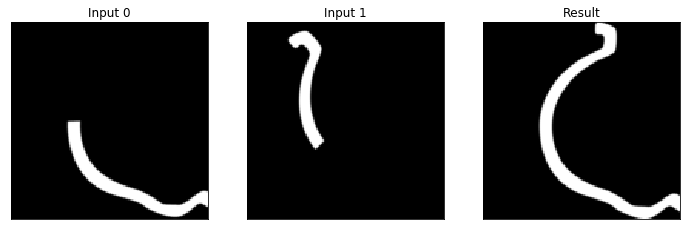

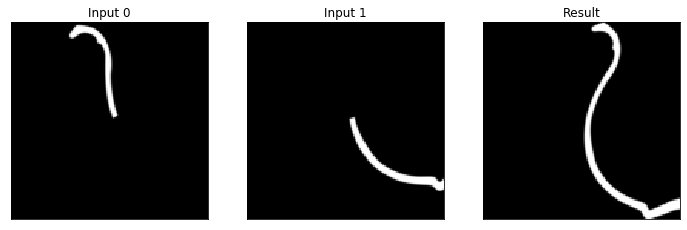

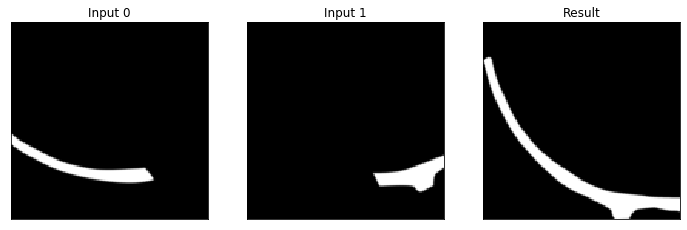

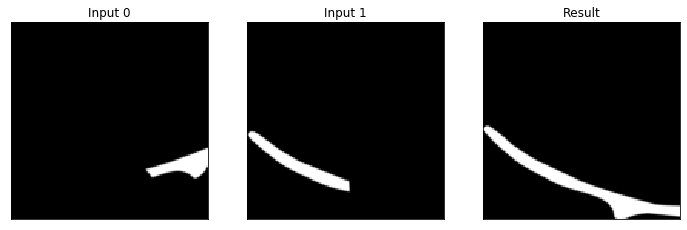

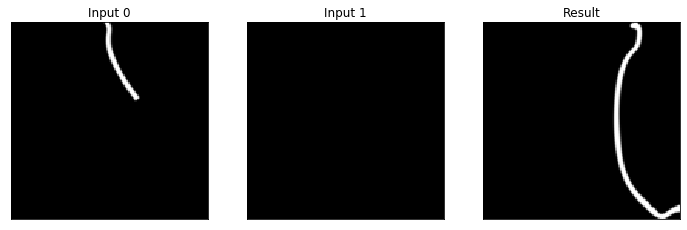

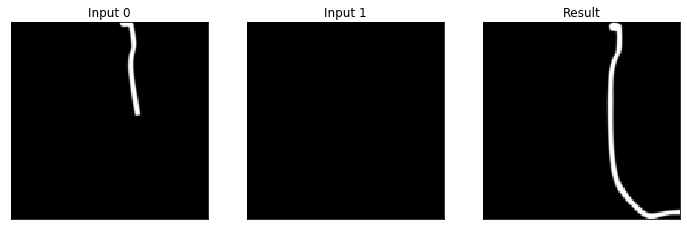

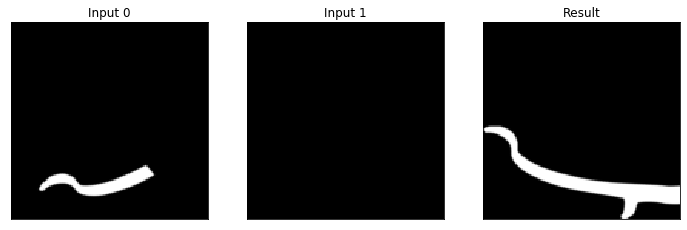

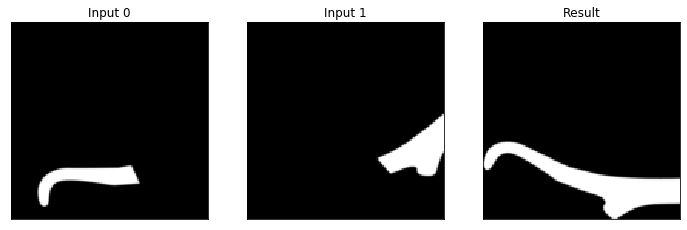

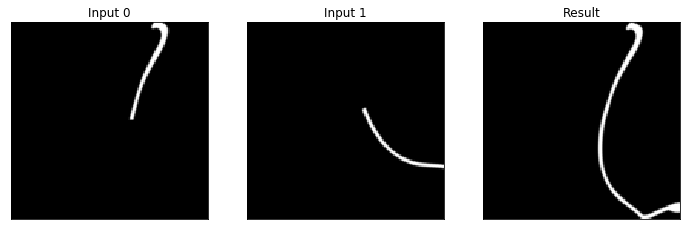

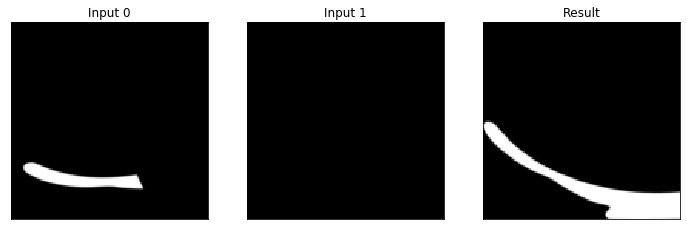

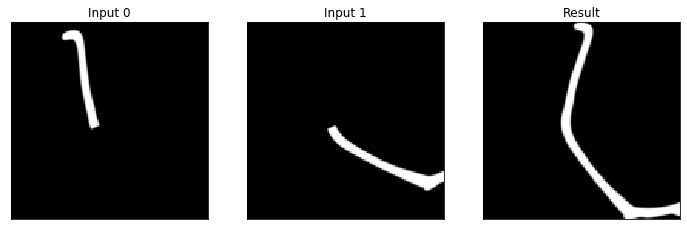

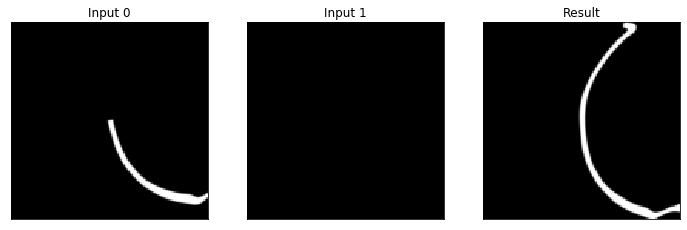

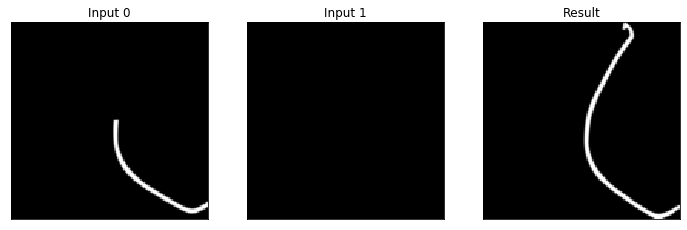

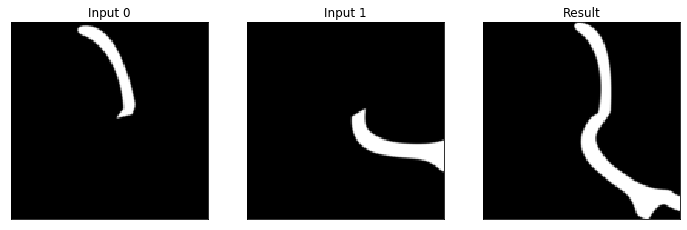

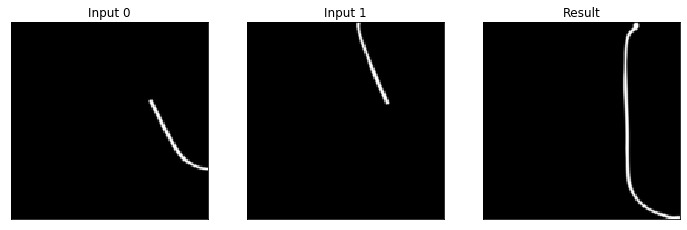

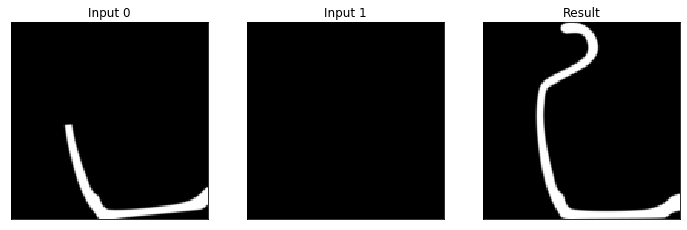

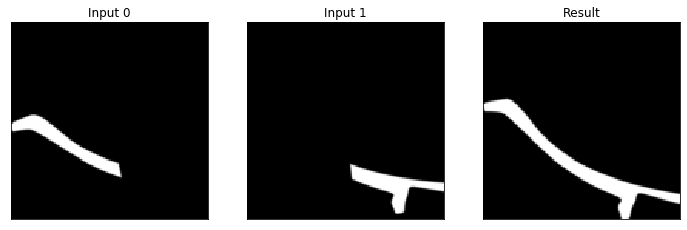

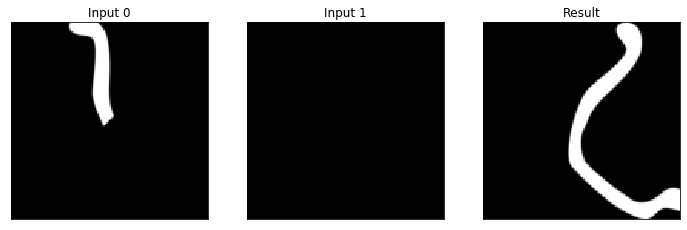

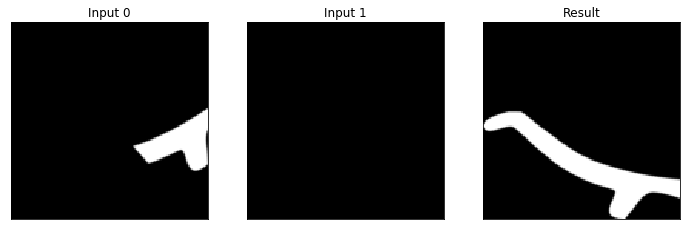

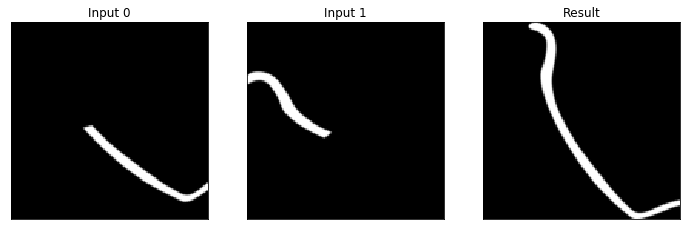

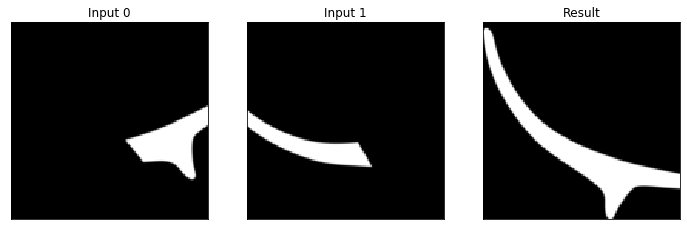

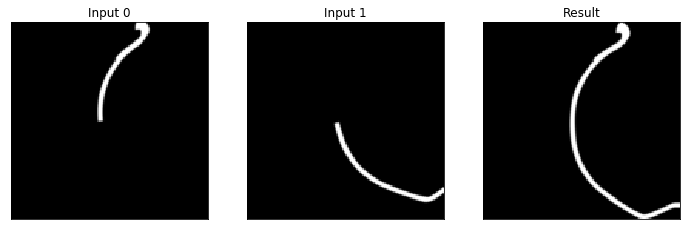

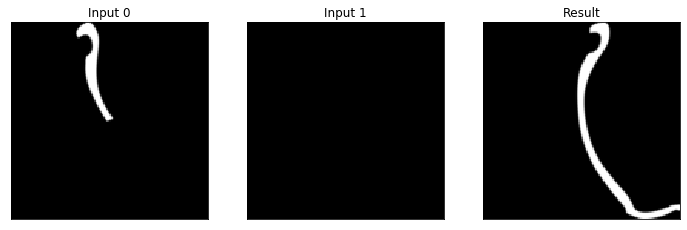

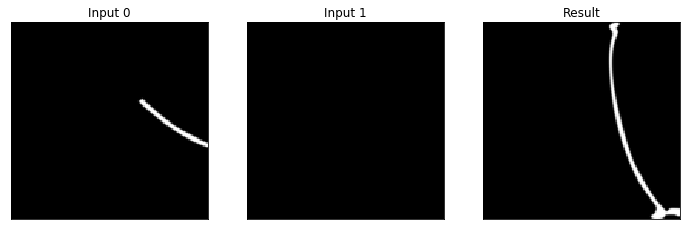

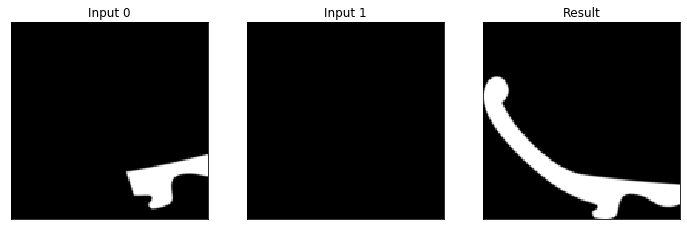

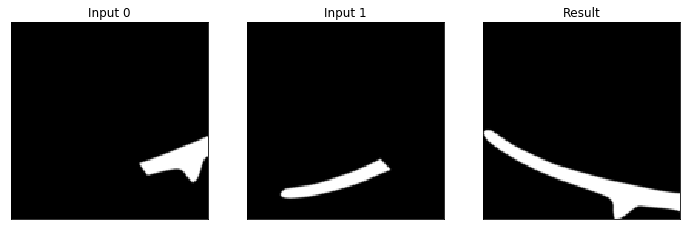

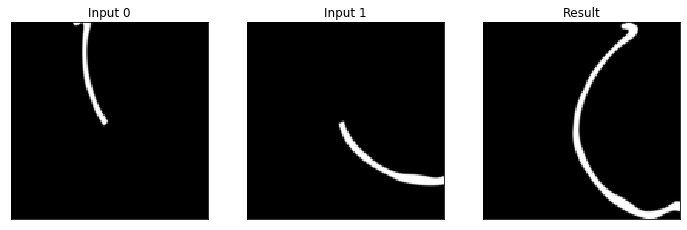

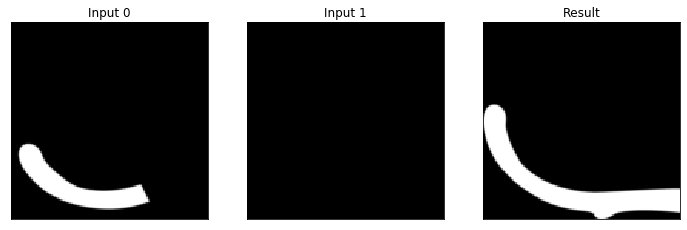

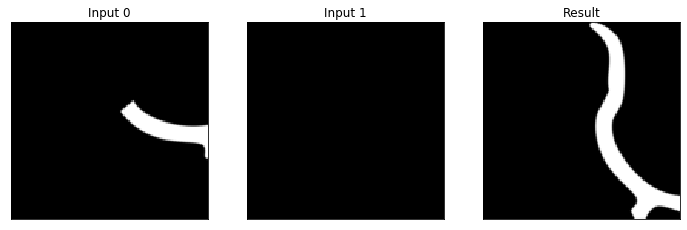

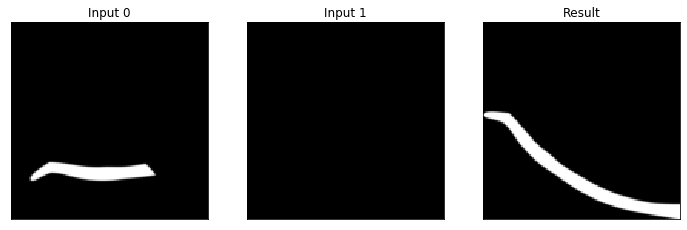

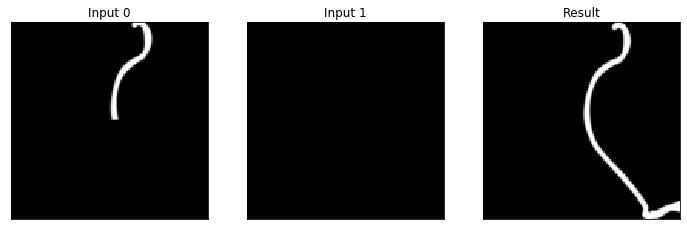

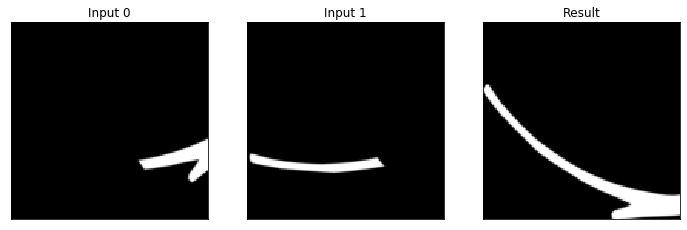

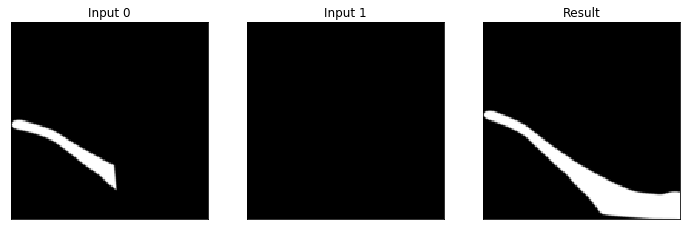

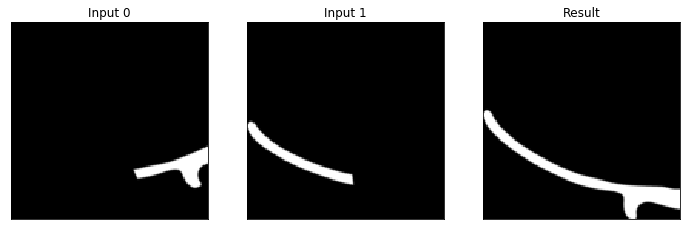

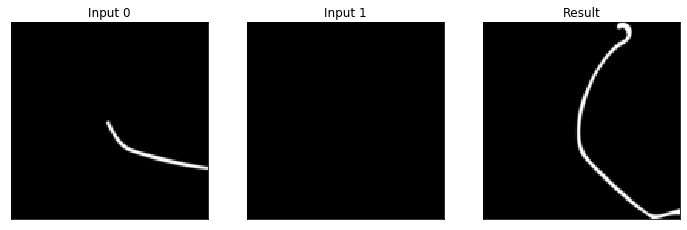

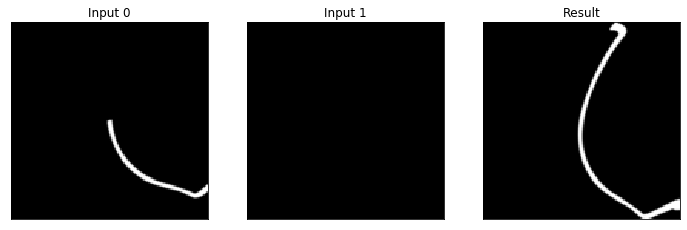

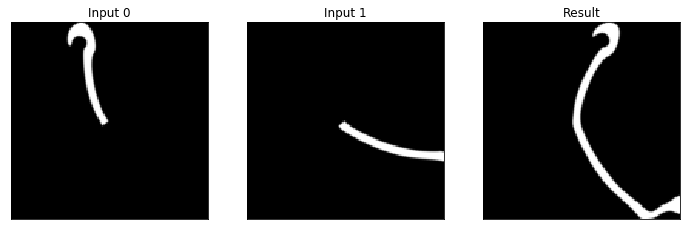

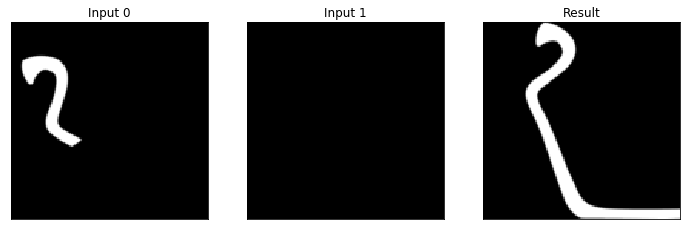

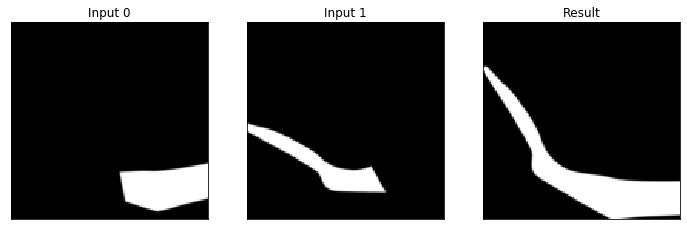

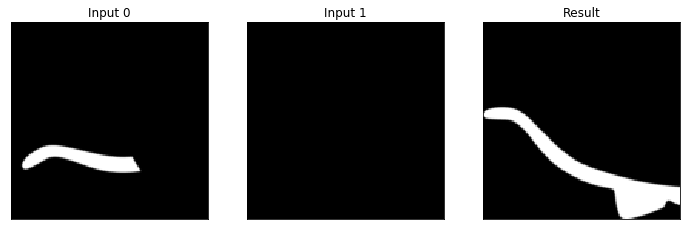

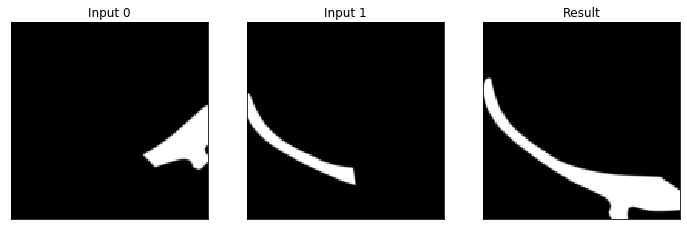

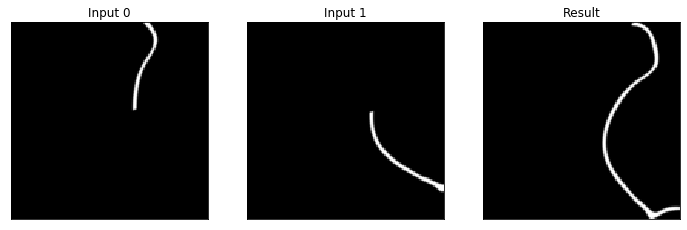

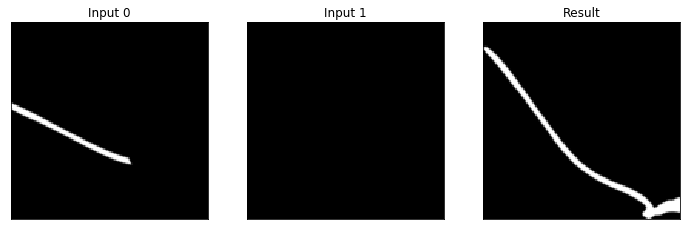

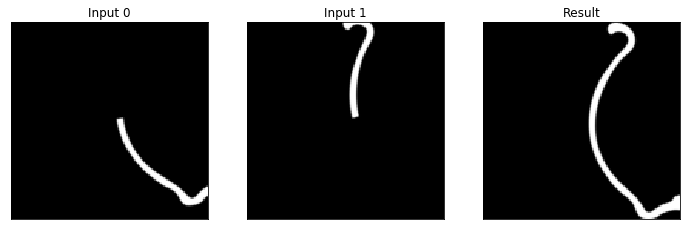

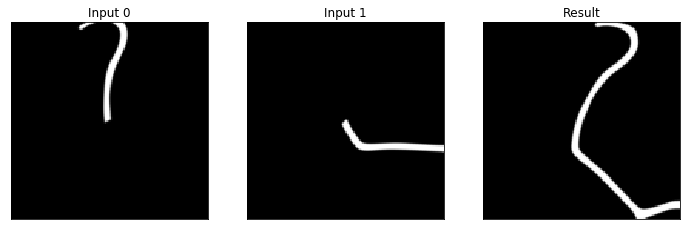

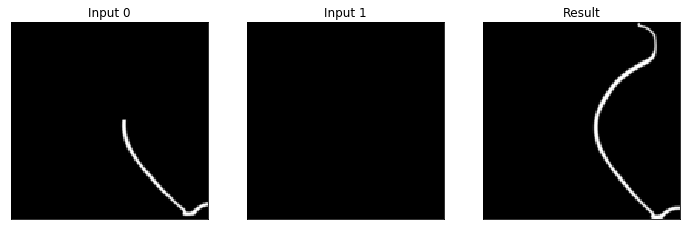

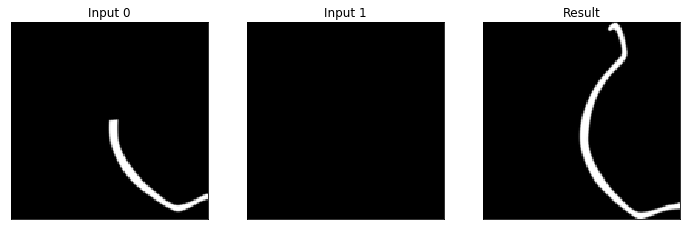

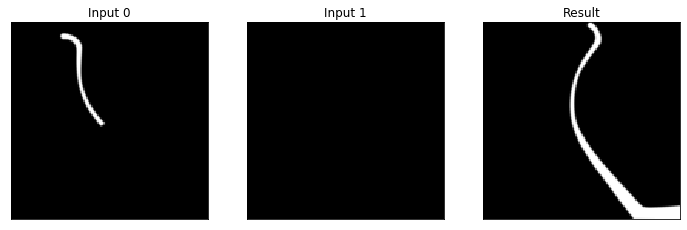

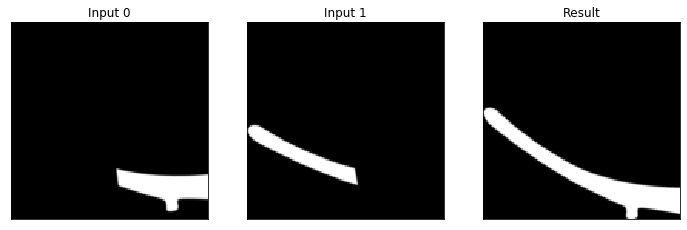

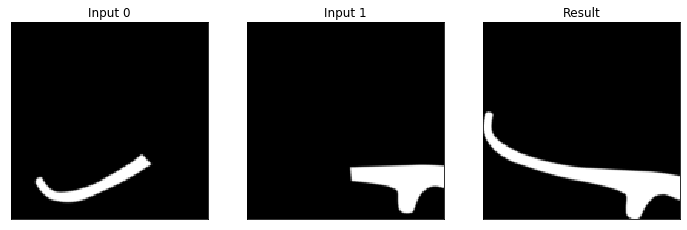

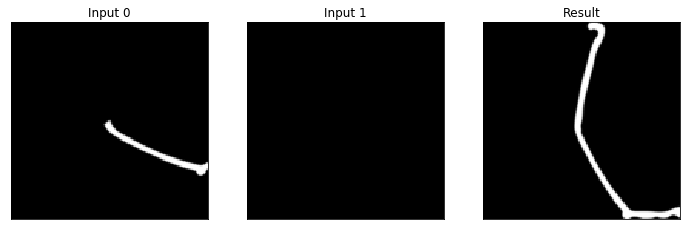

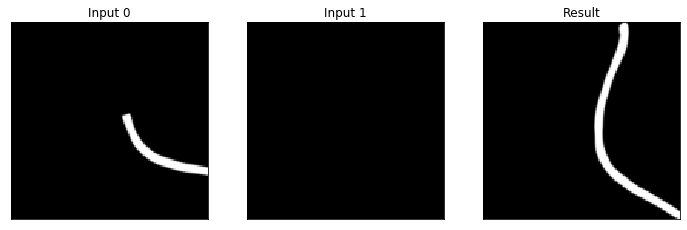

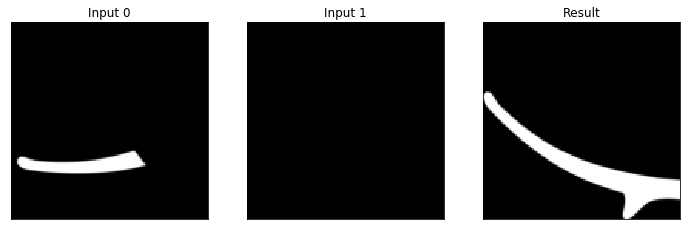

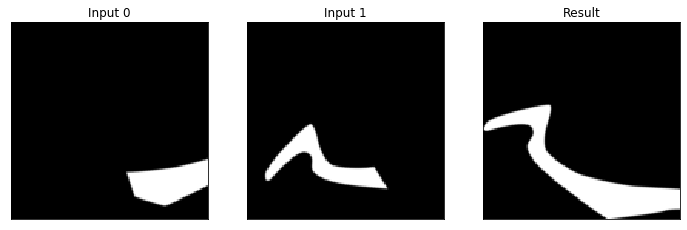

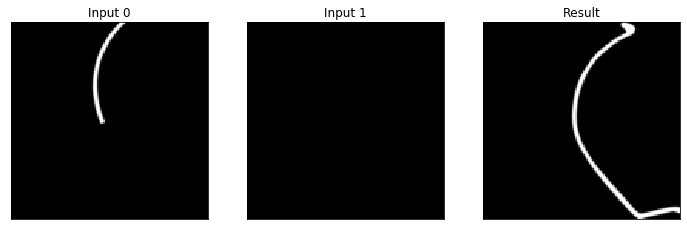

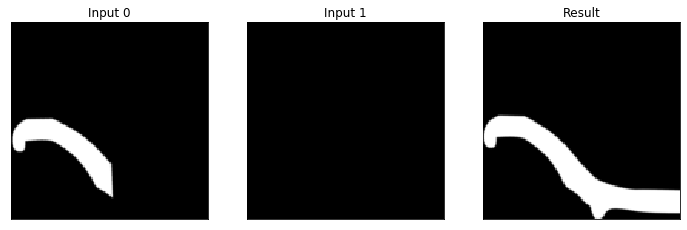

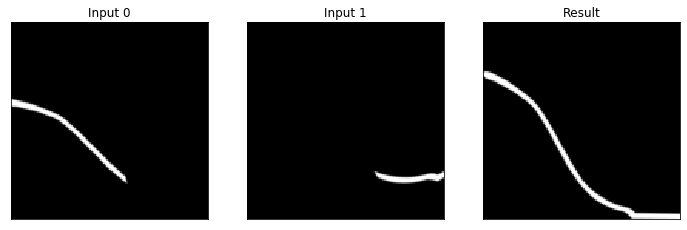

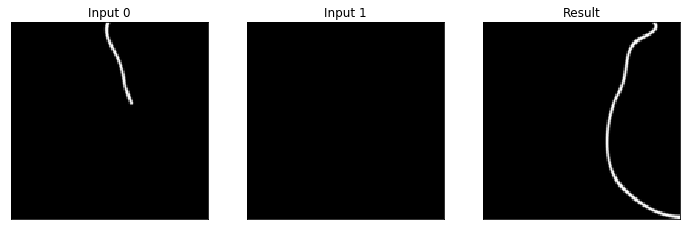

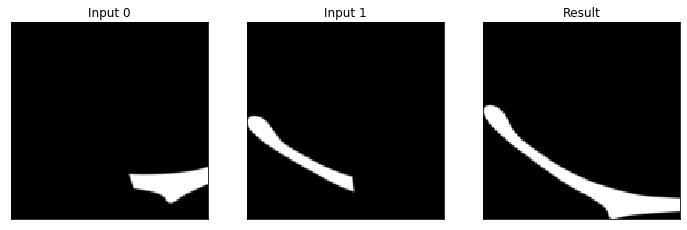

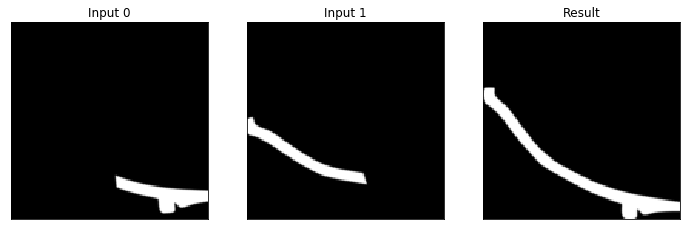

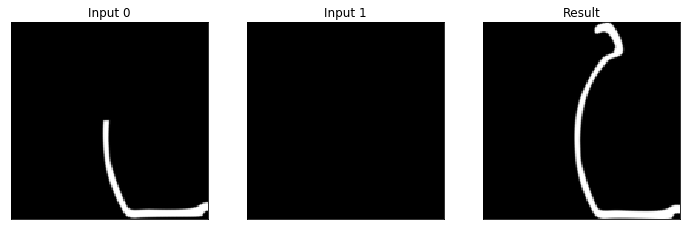

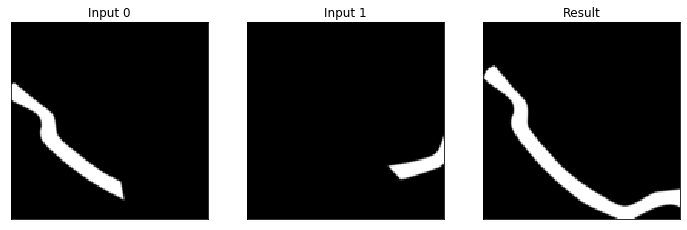

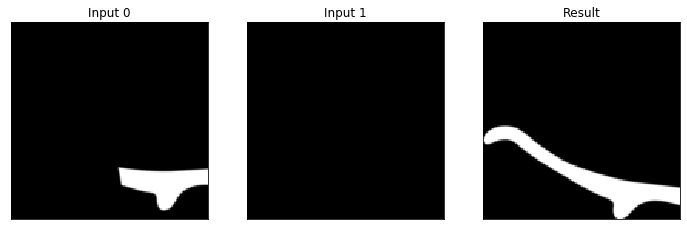

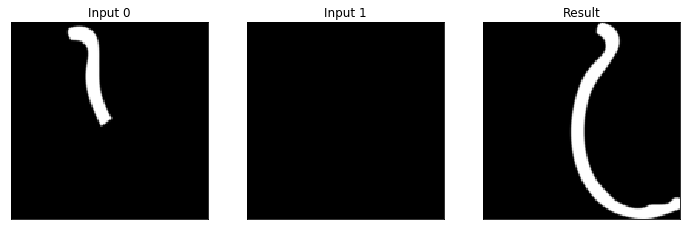

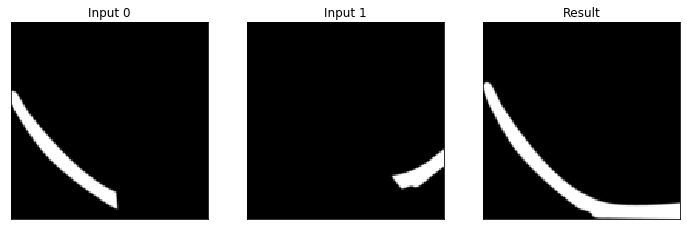

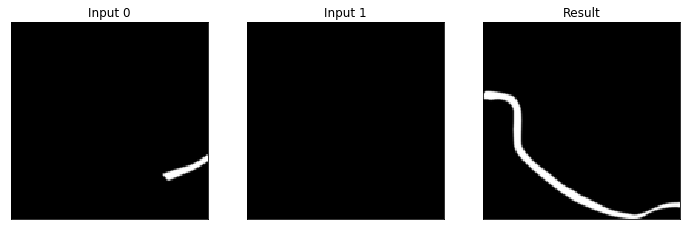

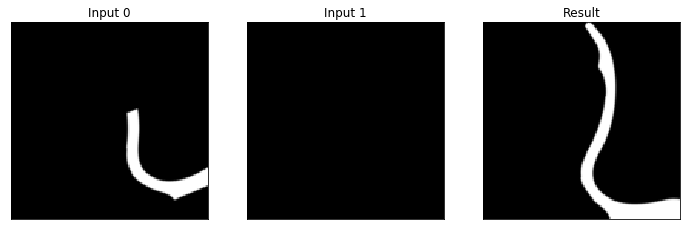

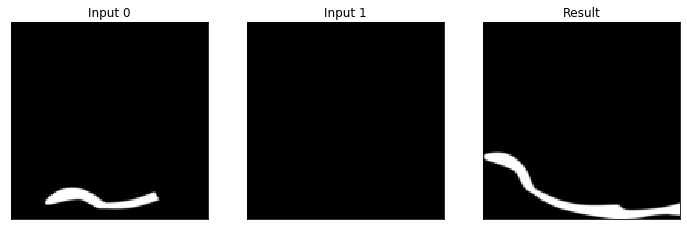

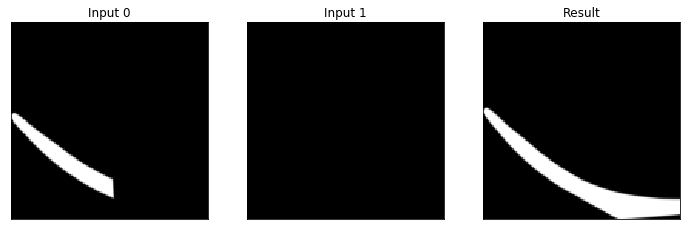

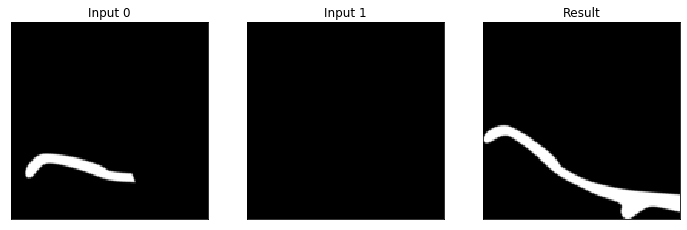

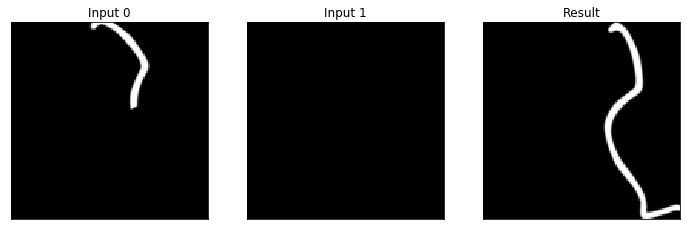

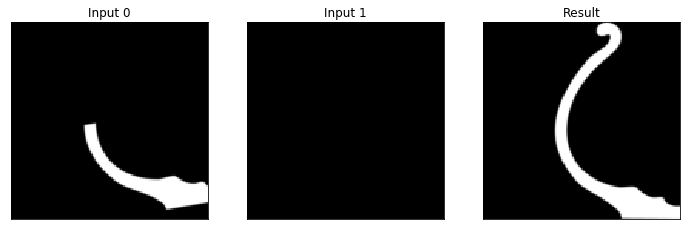

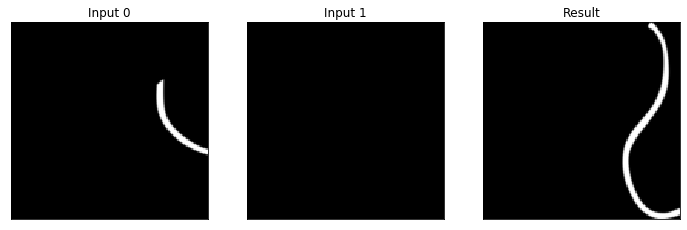

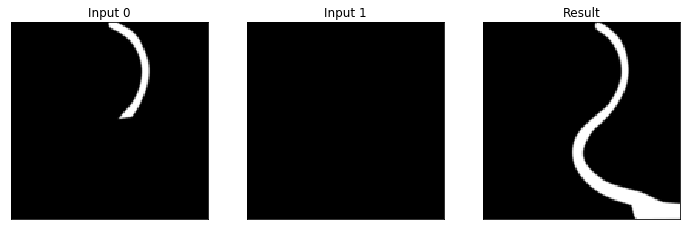

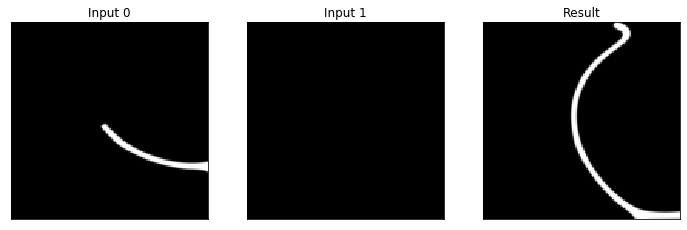

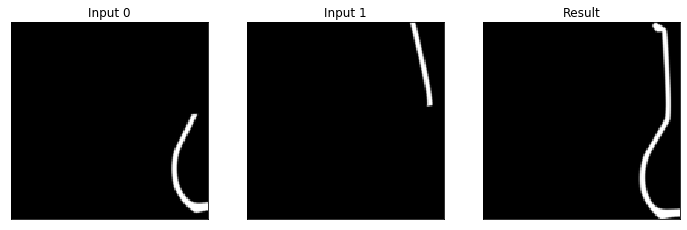

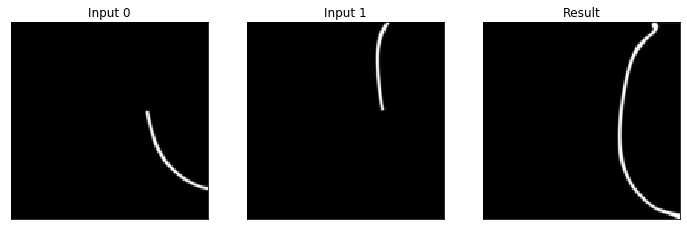

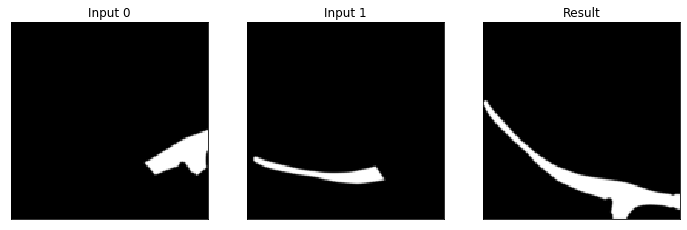

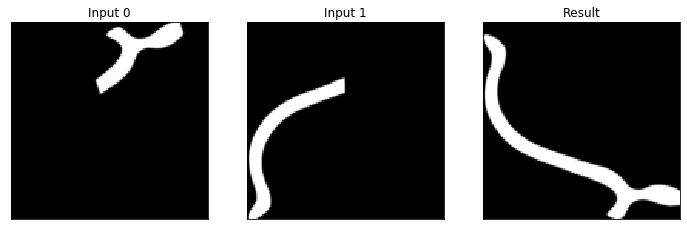

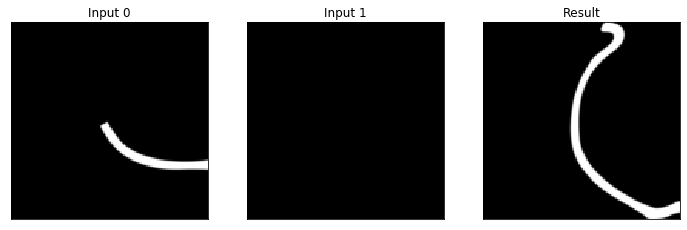

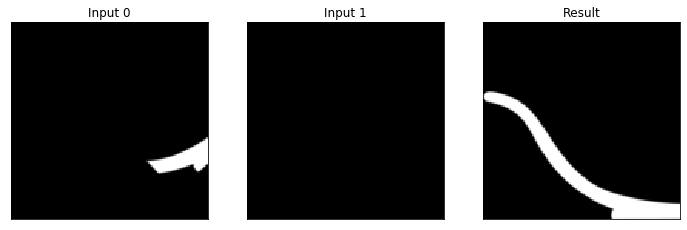

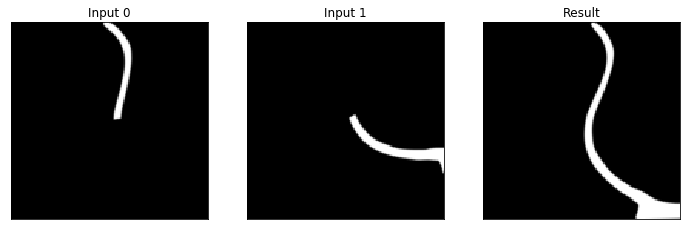

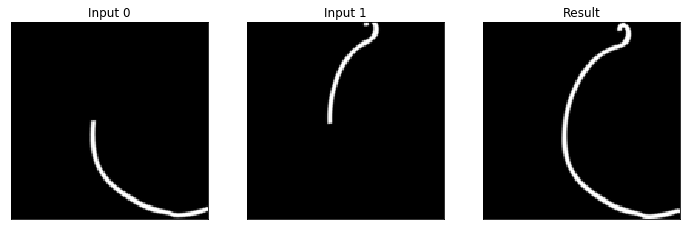

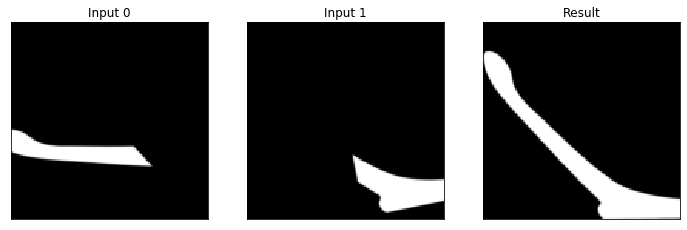

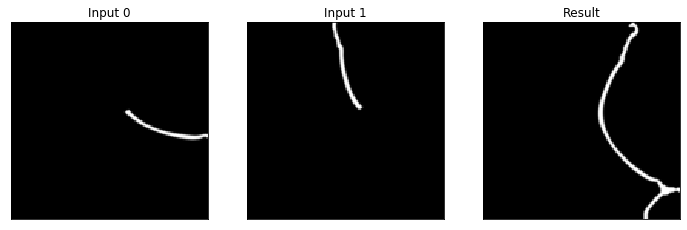

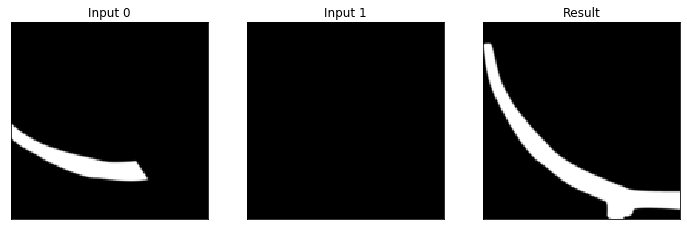

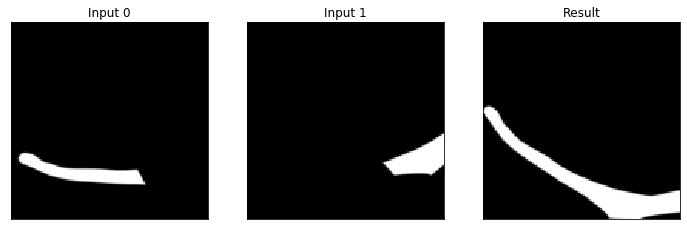

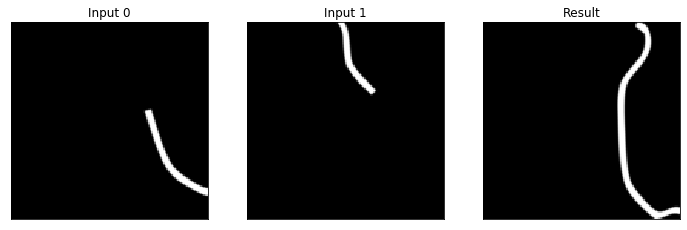

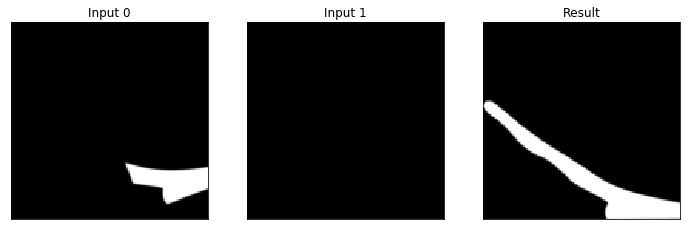

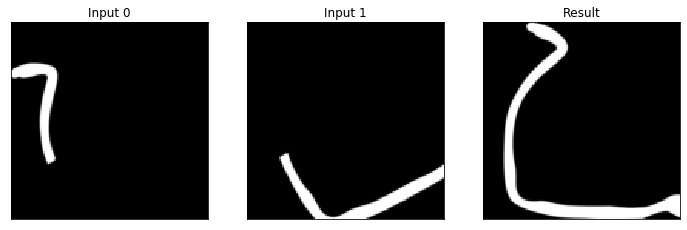

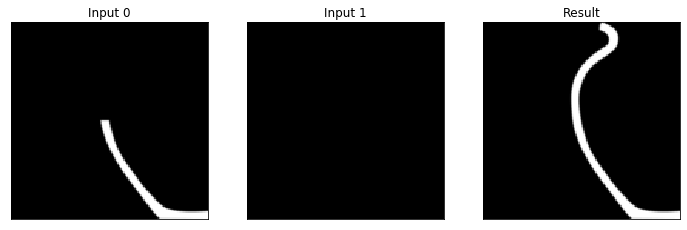

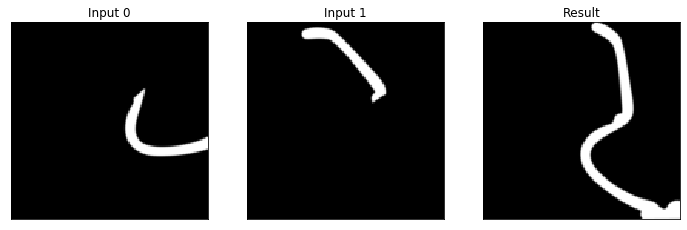

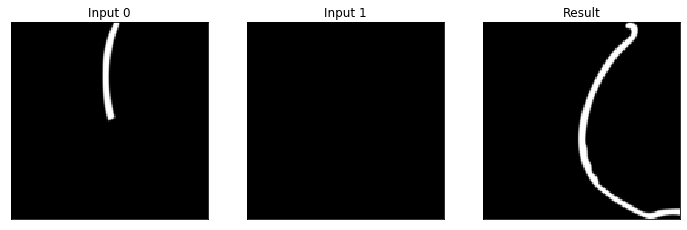

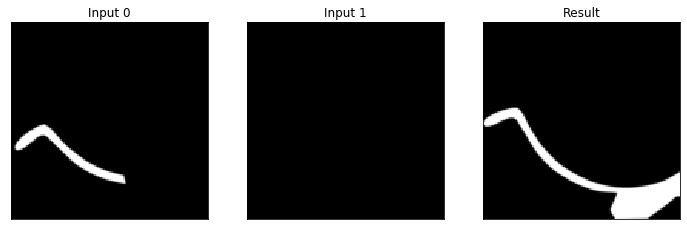

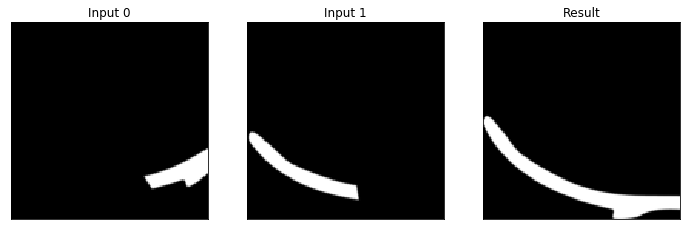

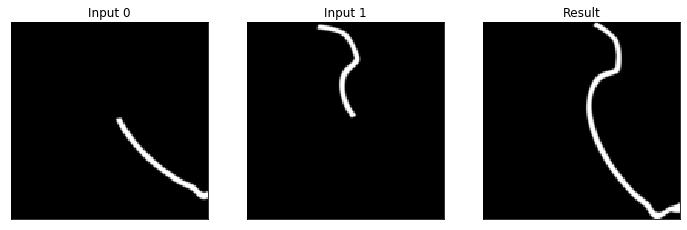

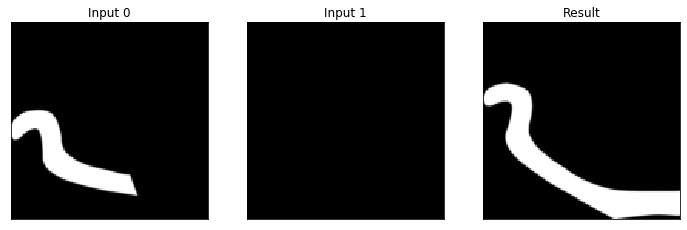

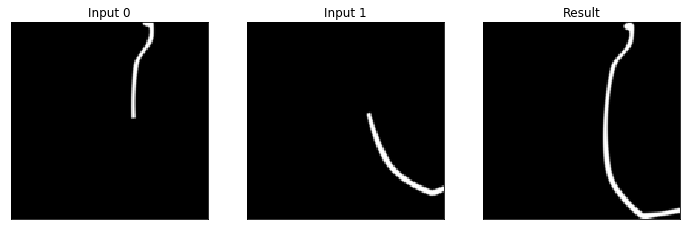

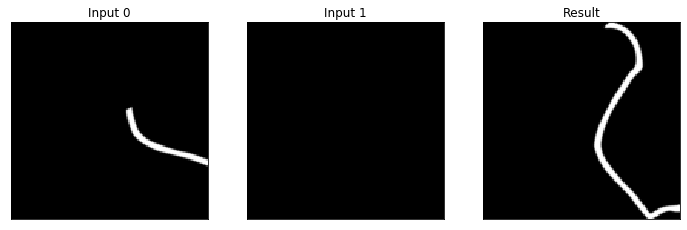

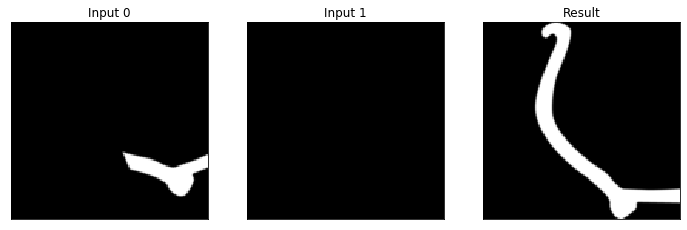

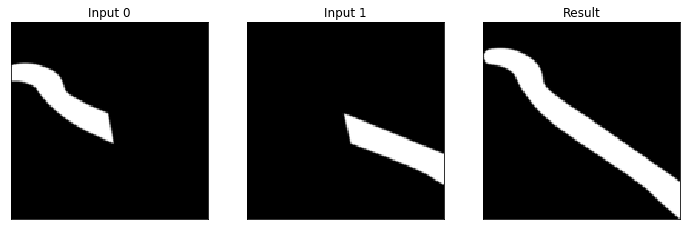

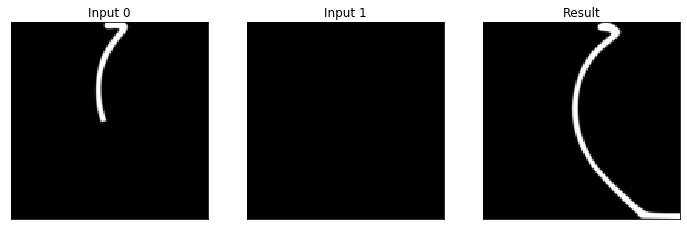

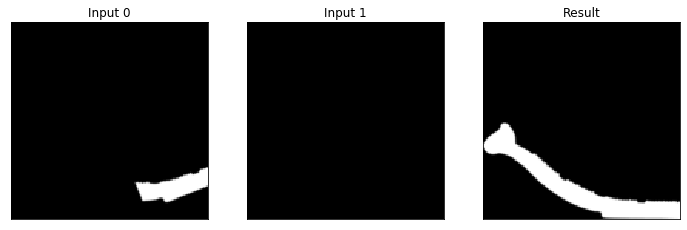

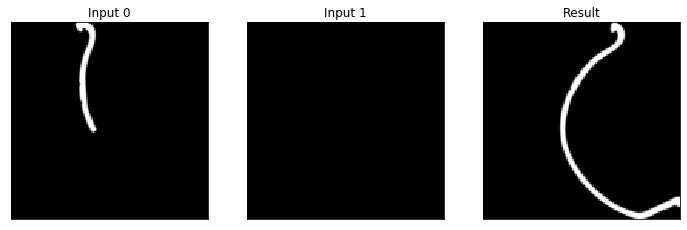

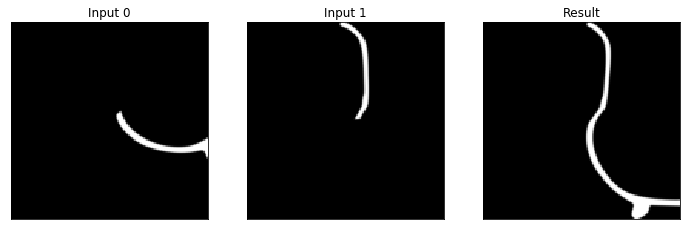

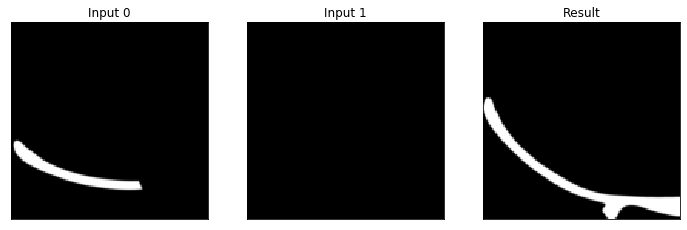

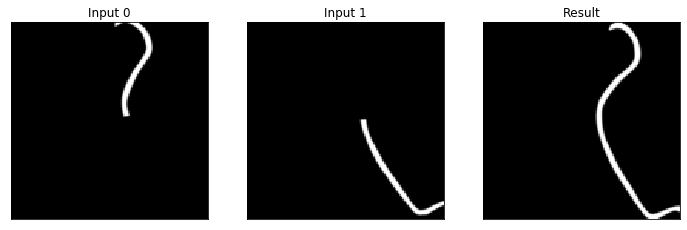

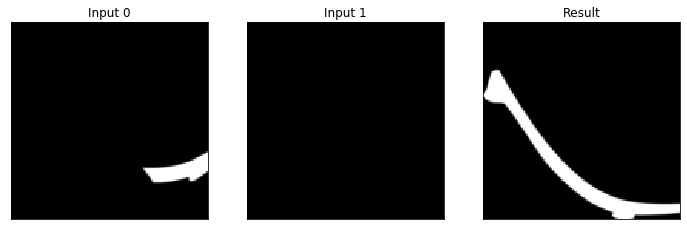

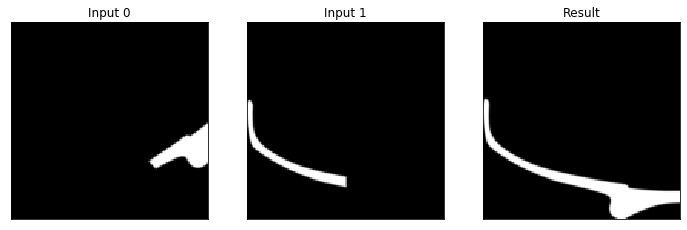

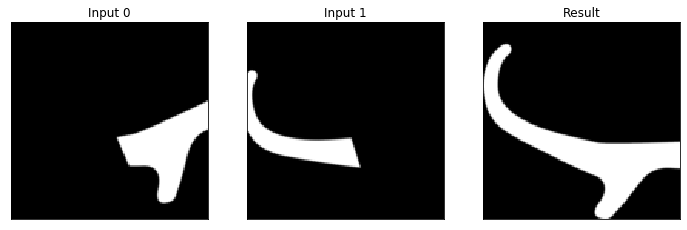

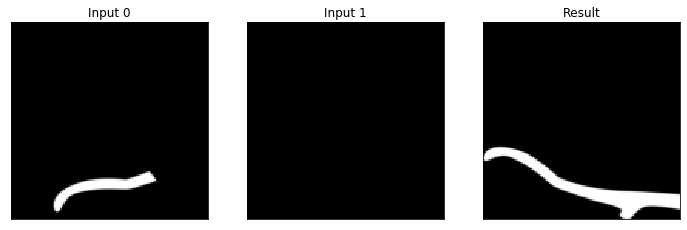

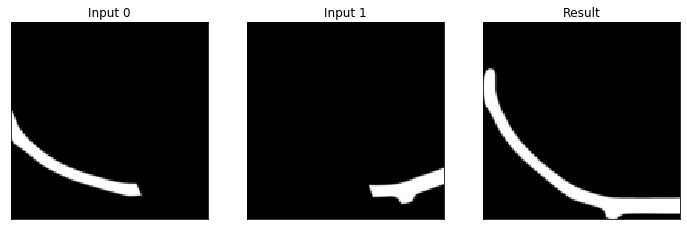

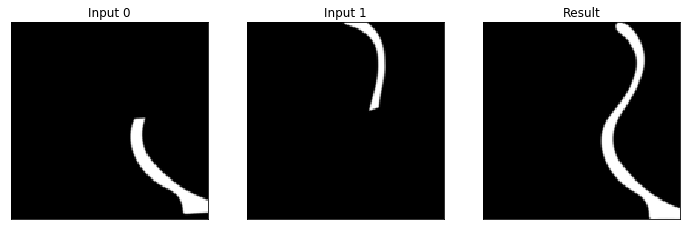

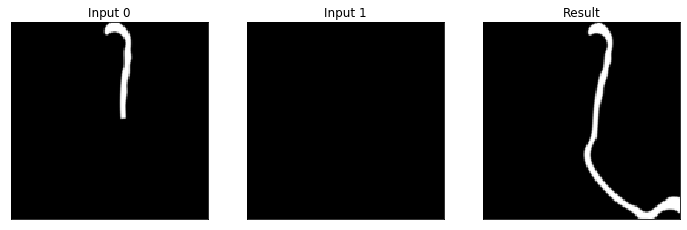

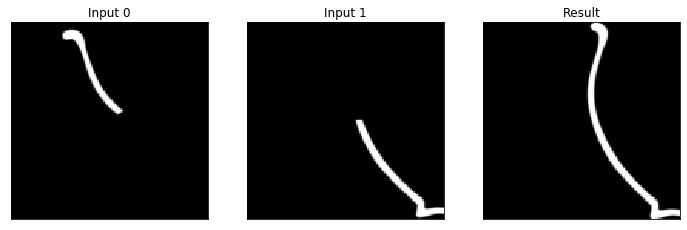

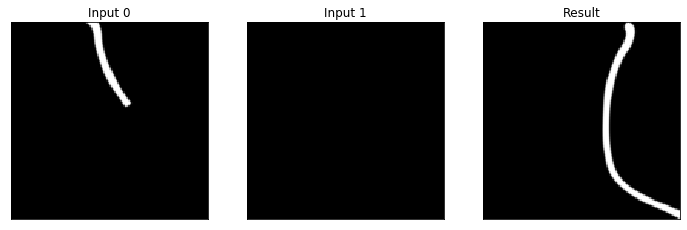

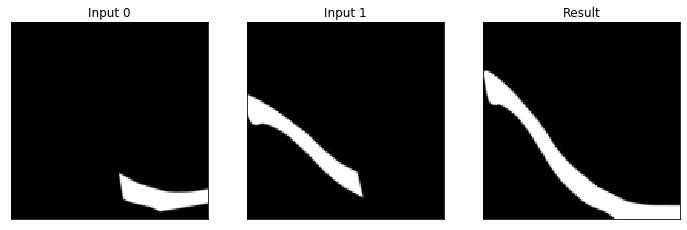

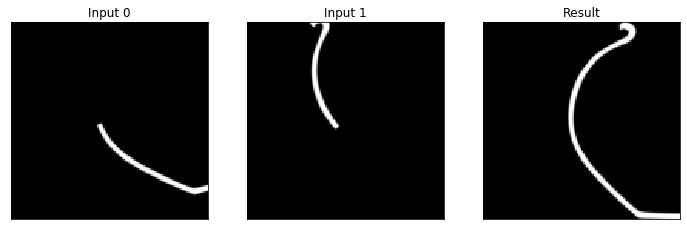

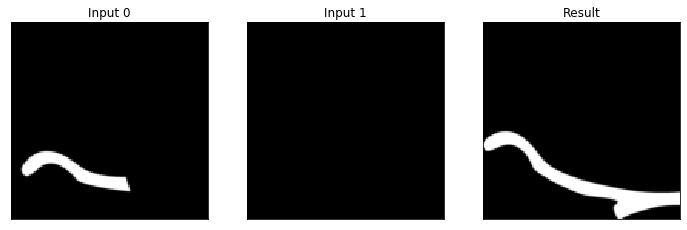

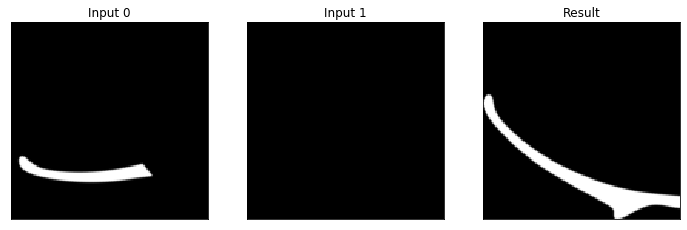

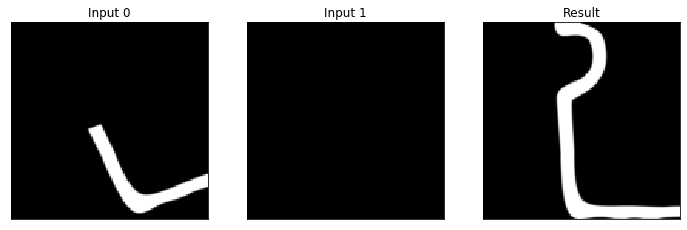

In [ ]:

v = 0
for batch, (image, labels, ids_name, tope, base, o_tope, o_base) in enumerate(test_loader, 0):
    tope, base, image = tope.to(available_device), base.to(available_device), image.to(available_device)
    o_tope, o_base = o_tope.to(available_device), o_base.to(available_device)
    
    blacks = torch.zeros_like(tope).to(available_device)
    target = torch.cat((tope, base, image), 1)    
    predicted_show = torch.cat((tope, base, blacks, image), 1)
    for i in range(predicted_show.shape[0]):
        imshow_msk_v2(predicted_show[i].detach().cpu().numpy(), v)
        v += 1


In [12]:
'''x
v = 0
for batch, (image, labels, ids_name, tope, base, o_tope, o_base) in enumerate(test_loader, 0):
    tope, base, image = tope.to(available_device), base.to(available_device), image.to(available_device)
    o_tope, o_base = o_tope.to(available_device), o_base.to(available_device)
    
    blacks = torch.zeros_like(tope).to(available_device)
    target = torch.cat((tope, base, image), 1)    
    predicted_show = torch.cat((o_tope, o_base, blacks, image), 1)
    for i in range(predicted_show.shape[0]):
        imshow_msk_v3(predicted_show[i].detach().cpu().numpy(), v)
        v += 1
'''

'x\nv = 0\nfor batch, (image, labels, ids_name, tope, base, o_tope, o_base) in enumerate(test_loader, 0):\n    tope, base, image = tope.to(available_device), base.to(available_device), image.to(available_device)\n    o_tope, o_base = o_tope.to(available_device), o_base.to(available_device)\n    \n    blacks = torch.zeros_like(tope).to(available_device)\n    target = torch.cat((tope, base, image), 1)    \n    predicted_show = torch.cat((o_tope, o_base, blacks, image), 1)\n    for i in range(predicted_show.shape[0]):\n        imshow_msk_v3(predicted_show[i].detach().cpu().numpy(), v)\n        v += 1\n'